In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torch.autograd import Variable
from torchsummary import summary
import os
from tqdm import tqdm
import random

C:\Users\andyc\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=2, batch_norm=False):
        super().__init__()
        layers = []
        conv2_params = {'kernel_size': (3, 3),
                        'stride'    : (1, 1),
                        'padding'   : 1}
        noop = lambda x : x
        bn = nn.BatchNorm2d if batch_norm else noop

        for i in range(num_convs):
            conv_in_channels = in_channels if i == 0 else out_channels
            layers += [nn.Conv2d(conv_in_channels, out_channels, **conv2_params)]
            layers += [bn(out_channels)]
            layers += [nn.ReLU(inplace=True)]

        self.features = nn.Sequential(*layers)
        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    def forward(self, x):
        x = self.features(x)
        x = self.max_pooling(x)
        return x

class VGG16For224(nn.Module):
    def __init__(self, input_size, num_classes=3, batch_norm=False):
        super(VGG16For224, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        # 針對 224x224 輸入調整 VGGBlock 的數量
        self.block_1 = VGGBlock(self.in_channels, 64, num_convs=2, batch_norm=batch_norm) # Output: 112x112
        self.block_2 = VGGBlock(64, 128, num_convs=2, batch_norm=batch_norm)        # Output: 56x56
        self.block_3 = VGGBlock(128, 256, num_convs=3, batch_norm=batch_norm)       # Output: 28x28
        self.block_4 = VGGBlock(256, 512, num_convs=3, batch_norm=batch_norm)       # Output: 14x14
        self.block_5 = VGGBlock(512, 512, num_convs=3, batch_norm=batch_norm)       # Output: 7x7

        # 調整 AdaptiveAvgPool2d 的輸出大小以適應後面的全連接層 (這裡輸出已經是 7x7)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    @property
    def input_size(self):
        return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, input_channels=3):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        model_url = model_urls[arch]
        state_dict = load_state_dict_from_url(model_url,
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f9561.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d1f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed6d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4526.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [3]:
def load_afhq_dataset_for_vgg_224_subset(root_dir, batch_size=32, subset_ratio=0.1):
    """
    加載 AFHQ 數據集的子集，調整圖像到 224x224，並根據子目錄名稱自動標記圖像，以適應 VGG16 模型。
    確保子集中包含所有類別。

    Args:
        root_dir (str): 數據集根目錄的相對路徑 (例如: '.../afhq').
        batch_size (int): 加載數據時的批次大小。
        subset_ratio (float): 子集比例 (例如: 0.1 表示載入約十分之一的數據)。

    Returns:
        tuple: 包含訓練集 DataLoader 和驗證集 DataLoader (子集)，以及類別名稱。
    """
    img_size = 224
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    full_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x),
                                             data_transforms[x])
                     for x in ['train', 'val']}

    subset_datasets = {}
    for phase in ['train', 'val']:
        full_dataset = full_datasets[phase]
        targets = full_dataset.targets
        classes = full_dataset.classes
        indices = []

        for class_index in range(len(classes)):
            class_indices = [i for i, target in enumerate(targets) if target == class_index]
            num_samples_per_class = int(len(class_indices) * subset_ratio)

            if num_samples_per_class > 0:
                # 確保每個類別至少有一個樣本
                samples_to_take = max(1, num_samples_per_class)
                random.shuffle(class_indices)
                indices.extend(class_indices[:samples_to_take])
            elif len(class_indices) > 0 and subset_ratio > 0:
                # 如果計算出的樣本數為 0 但類別存在，則強制添加一個樣本
                indices.append(random.choice(class_indices))

        random.shuffle(indices)
        subset_datasets[phase] = Subset(full_dataset, indices)

    dataloaders = {x: DataLoader(subset_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
                     for x in ['train', 'val']}

    return dataloaders['train'], dataloaders['val'], full_datasets['train'].classes

In [4]:
def load_afhq_dataset_split(root_dir, batch_size=32, img_size=128, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=None):
    """
    加載 AFHQ 數據集（考慮 train 和 val 子目錄），調整圖像大小，創建訓練集、驗證集和測試集 DataLoader，
    並可選地縮小數據集大小，確保每個劃分包含所有類別。
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "訓練、驗證和測試比例之和必須為 1.0"

    data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset_full = datasets.ImageFolder(os.path.join(root_dir, 'train'), transform=data_transforms)
    val_dataset_full = datasets.ImageFolder(os.path.join(root_dir, 'val'), transform=data_transforms)
    class_names = train_dataset_full.classes

    train_indices = list(range(len(train_dataset_full)))
    val_indices = list(range(len(val_dataset_full)))
    random.shuffle(train_indices)
    random.shuffle(val_indices)

    if subset_ratio is not None and 0 < subset_ratio <= 1:
        train_num_samples = int(len(train_dataset_full) * subset_ratio)
        val_num_samples = int(len(val_dataset_full) * subset_ratio)
        if train_num_samples > 0 and val_num_samples > 0:
            train_indices = sorted(random.sample(train_indices, train_num_samples))
            val_indices = sorted(random.sample(val_indices, val_num_samples))
            train_dataset_full = Subset(train_dataset_full, train_indices)
            val_dataset_full = Subset(val_dataset_full, val_indices)
            print(f"訓練集和驗證集已縮小至約 {subset_ratio * 100:.1f}% 的大小。")
        else:
            print("警告: subset_ratio 太小，無法選取任何訓練或驗證樣本。")
            return None, None, None, class_names

    train_size = int(train_ratio * len(train_dataset_full))
    val_size = int(val_ratio * len(train_dataset_full)) # 使用訓練集大小作為劃分的基礎
    remaining_size = len(train_dataset_full) - train_size - val_size

    # 從訓練集中劃分出訓練集、驗證集和剩餘部分
    train_dataset, temp_dataset = random_split(train_dataset_full, [train_size, len(train_dataset_full) - train_size], generator=torch.Generator().manual_seed(42))
    val_dataset, test_dataset = random_split(temp_dataset, [val_size, len(temp_dataset) - val_size], generator=torch.Generator().manual_seed(42))

    def ensure_all_classes(dataset, full_dataset, class_names):
        dataset_indices = dataset.indices
        dataset_targets = [full_dataset.targets[i] for i in dataset_indices]
        present_classes = set(dataset_targets)
        needed_indices = []
        all_full_indices = list(range(len(full_dataset)))
        for i, class_index in enumerate(range(len(class_names))):
            if class_index not in present_classes:
                class_all_indices = [idx for idx in all_full_indices if full_dataset.targets[idx] == class_index]
                if class_all_indices:
                    needed_indices.append(class_all_indices[0])
                    dataset_indices.append(class_all_indices[0])
                    dataset = Subset(full_dataset, sorted(list(set(dataset_indices))))
        return dataset

    if subset_ratio is not None and subset_ratio > 0:
        train_dataset = ensure_all_classes(train_dataset, train_dataset_full.dataset, class_names)
        val_dataset = ensure_all_classes(val_dataset, train_dataset_full.dataset, class_names)
        test_dataset = ensure_all_classes(test_dataset, train_dataset_full.dataset, class_names)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, class_names

In [8]:
if __name__ == '__main__':
    relative_path = 'afhq' # 請將 '...' 替換為您的實際相對路徑
    absolute_path = os.path.abspath(relative_path)

    try:
        num_classes = 3
        input_size = (3, 224, 224) # 輸入圖像大小為 512x512 RGB
        model = VGG16For224(input_size=input_size, num_classes=num_classes, batch_norm=True)

        train_dataloader, test_dataloader, class_names = load_afhq_dataset_for_vgg_224_subset(absolute_path, batch_size=16, subset_ratio=0.1) # 設定子集比例為 0.1
        print("子集數據集已成功加載！")
        print(f"類別名稱: {class_names}")
        print(f"訓練集批次數量 (子集): {len(train_dataloader)}")
        print(f"驗證集批次數量 (子集): {len(val_dataloader)}")
        print(f"模型輸入大小: {model.input_size}")
        print(f"模型輸出類別數: {model.classifier[-1].out_features}")

        assert len(class_names) == model.classifier[-1].out_features, \
            f"類別數量 ({len(class_names)}) 與模型輸出類別數 ({model.classifier[-1].out_features}) 不匹配！"

        # 您可以迭代 DataLoader 來查看數據子集
        for inputs, labels in train_dataloader:
            print("輸入張量的形狀 (子集):", inputs.shape)
            print("標籤張量的形狀 (子集):", labels.shape)
            print("一個批次的標籤 (子集):", labels)
            output = model(inputs) # 將輸入傳遞給模型
            print("模型輸出形狀 (子集):", output.shape)
            break

    except FileNotFoundError:
        print(f"錯誤：找不到位於 {absolute_path} 的數據集目錄。請檢查路徑是否正確。")
    except Exception as e:
        print(f"加載數據集或模型時發生錯誤：{e}")

子集數據集已成功加載！
類別名稱: ['cat', 'dog', 'wild']
訓練集批次數量 (子集): 92
驗證集批次數量 (子集): 10
模型輸入大小: (3, 224, 224)
模型輸出類別數: 3
輸入張量的形狀 (子集): torch.Size([16, 3, 224, 224])
標籤張量的形狀 (子集): torch.Size([16])
一個批次的標籤 (子集): tensor([0, 2, 0, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1])
模型輸出形狀 (子集): torch.Size([16, 3])


In [19]:
def load_afhq_dataset_for_resnet_18_subset(data_dir, batch_size=32, subset_ratio=0.1):
    """
    加載 AFHQ 數據集的一個子集，並為 ResNet18 準備 DataLoader。

    Args:
        data_dir (str): AFHQ 數據集的根目錄。
        batch_size (int): DataLoader 的批次大小。
        subset_ratio (float): 使用數據集的比例 (0 到 1)。

    Returns:
        tuple: 包含訓練 DataLoader, 驗證 DataLoader, 和類別名稱列表。
    """
    class_names = sorted(os.listdir(data_dir))
    train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)

    # 創建子集
    train_indices = torch.randperm(len(train_dataset))[:int(subset_ratio * len(train_dataset))]
    val_indices = torch.randperm(len(val_dataset))[:int(subset_ratio * len(val_dataset))]

    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(val_dataset, val_indices)

    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_dataloader, val_dataloader, class_names

def train_resnet18(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    """
    訓練 ResNet18 模型。

    Args:
        model (nn.Module): 要訓練的 ResNet18 模型。
        train_loader (DataLoader): 訓練數據的 DataLoader。
        val_loader (DataLoader): 驗證數據的 DataLoader。
        criterion (nn.Module): 損失函數。
        optimizer (optim.Optimizer): 優化器。
        device (torch.device): 模型運行的設備。
        num_epochs (int): 訓練的 epoch 數量。
    """
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=f"{train_loss / total_train:.4f}", acc=f"{100 * train_correct / total_train:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / total_train:.4f}, Train Accuracy: {100 * train_correct / total_train:.2f}%')

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
            for inputs, labels in progress_bar_val:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                progress_bar_val.set_postfix(loss=f"{val_loss / total_val:.4f}", acc=f"{100 * val_correct / total_val:.2f}%")

        val_accuracy = 100 * val_correct / total_val
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / total_val:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return model

if __name__ == '__main__':
    import torch
    import torchvision.models as models

    relative_path = 'afhq' # 請將 'afhq' 替換為您的實際 AFHQ 資料集路徑
    absolute_path = os.path.abspath(relative_path)

    try:
        num_classes = 3
        input_size = (3, 224, 224)
        batch_size = 16
        learning_rate = 0.001
        num_epochs = 10
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        train_dataloader, val_dataloader, class_names = load_afhq_dataset_for_resnet_18_subset(absolute_path, batch_size=batch_size, subset_ratio=1.0)
        print("子集數據集已成功加載！")
        print(f"類別名稱: {class_names}")
        print(f"訓練集批次數量 (子集): {len(train_dataloader)}")
        print(f"驗證集批次數量 (子集): {len(val_dataloader)}")
        print(f"模型輸入大小: {input_size}")
        print(f"模型輸出類別數: {num_classes}")

        # 加載預訓練的 ResNet18 模型
        model = models.resnet18(pretrained=True)

        # 凍結 ResNet18 的部分層 (可選)
        # for param in model.parameters():
        #     param.requires_grad = False

        # 替換最後的全連接層以適應您的類別數量
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # 訓練模型
        trained_model = train_resnet18(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs)

        # 保存訓練好的模型
        torch.save(trained_model.state_dict(), 'resnet18_afhq_subset.pth')
        print("訓練好的 ResNet18 模型已保存為 resnet18_afhq_subset.pth")

    except FileNotFoundError:
        print(f"錯誤：找不到位於 {absolute_path} 的數據集目錄。請檢查路徑是否正確。")
    except Exception as e:
        print(f"加載數據集或模型時發生錯誤：{e}")

子集數據集已成功加載！
類別名稱: ['train', 'val']
訓練集批次數量 (子集): 915
驗證集批次數量 (子集): 94
模型輸入大小: (3, 224, 224)
模型輸出類別數: 3


Epoch 1/10 (Training): 100%|██████████| 915/915 [01:36<00:00,  9.52it/s, acc=95.43%, loss=0.1273]


Epoch [1/10], Train Loss: 0.1273, Train Accuracy: 95.43%


Epoch 1/10 (Validation): 100%|██████████| 94/94 [00:15<00:00,  5.99it/s, acc=97.47%, loss=0.0936]


Epoch [1/10], Validation Loss: 0.0936, Validation Accuracy: 97.47%


Epoch 2/10 (Training): 100%|██████████| 915/915 [01:27<00:00, 10.42it/s, acc=97.95%, loss=0.0627] 


Epoch [2/10], Train Loss: 0.0627, Train Accuracy: 97.95%


Epoch 2/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.14it/s, acc=98.67%, loss=0.0409]


Epoch [2/10], Validation Loss: 0.0409, Validation Accuracy: 98.67%


Epoch 3/10 (Training): 100%|██████████| 915/915 [01:28<00:00, 10.39it/s, acc=98.28%, loss=0.0530] 


Epoch [3/10], Train Loss: 0.0530, Train Accuracy: 98.28%


Epoch 3/10 (Validation): 100%|██████████| 94/94 [00:12<00:00,  7.30it/s, acc=98.80%, loss=0.0369]


Epoch [3/10], Validation Loss: 0.0369, Validation Accuracy: 98.80%


Epoch 4/10 (Training): 100%|██████████| 915/915 [01:27<00:00, 10.51it/s, acc=98.63%, loss=0.0424] 


Epoch [4/10], Train Loss: 0.0424, Train Accuracy: 98.63%


Epoch 4/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.00it/s, acc=99.40%, loss=0.0240]


Epoch [4/10], Validation Loss: 0.0240, Validation Accuracy: 99.40%


Epoch 5/10 (Training): 100%|██████████| 915/915 [01:28<00:00, 10.38it/s, acc=98.89%, loss=0.0319] 


Epoch [5/10], Train Loss: 0.0319, Train Accuracy: 98.89%


Epoch 5/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.11it/s, acc=99.27%, loss=0.0291]


Epoch [5/10], Validation Loss: 0.0291, Validation Accuracy: 99.27%


Epoch 6/10 (Training): 100%|██████████| 915/915 [01:29<00:00, 10.23it/s, acc=98.82%, loss=0.0373] 


Epoch [6/10], Train Loss: 0.0373, Train Accuracy: 98.82%


Epoch 6/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.03it/s, acc=98.20%, loss=0.0444]


Epoch [6/10], Validation Loss: 0.0444, Validation Accuracy: 98.20%


Epoch 7/10 (Training): 100%|██████████| 915/915 [01:27<00:00, 10.50it/s, acc=98.97%, loss=0.0334]


Epoch [7/10], Train Loss: 0.0334, Train Accuracy: 98.97%


Epoch 7/10 (Validation): 100%|██████████| 94/94 [00:14<00:00,  6.65it/s, acc=99.33%, loss=0.0258]


Epoch [7/10], Validation Loss: 0.0258, Validation Accuracy: 99.33%


Epoch 8/10 (Training): 100%|██████████| 915/915 [01:27<00:00, 10.47it/s, acc=99.19%, loss=0.0258] 


Epoch [8/10], Train Loss: 0.0258, Train Accuracy: 99.19%


Epoch 8/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.03it/s, acc=98.80%, loss=0.0389] 


Epoch [8/10], Validation Loss: 0.0389, Validation Accuracy: 98.80%


Epoch 9/10 (Training): 100%|██████████| 915/915 [01:27<00:00, 10.41it/s, acc=99.23%, loss=0.0272]


Epoch [9/10], Train Loss: 0.0272, Train Accuracy: 99.23%


Epoch 9/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.13it/s, acc=98.93%, loss=0.0253]


Epoch [9/10], Validation Loss: 0.0253, Validation Accuracy: 98.93%


Epoch 10/10 (Training): 100%|██████████| 915/915 [01:26<00:00, 10.53it/s, acc=99.28%, loss=0.0230] 


Epoch [10/10], Train Loss: 0.0230, Train Accuracy: 99.28%


Epoch 10/10 (Validation): 100%|██████████| 94/94 [00:13<00:00,  7.20it/s, acc=97.67%, loss=0.0636]

Epoch [10/10], Validation Loss: 0.0636, Validation Accuracy: 97.67%
訓練好的 ResNet18 模型已保存為 resnet18_afhq_subset.pth


In [10]:
def train_vgg16(root_dir, batch_size=16, img_size=224, learning_rate=0.001, num_epochs=10, use_cuda=True):
    # 檢查是否有 CUDA 可用
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    print(f"使用設備: {device}")

    # 載入數據
    train_loader, val_loader, test_loader, class_names = load_afhq_dataset_for_vgg_224_subset(root_dir, batch_size, img_size)
    num_classes = len(class_names)
    input_size = (3, img_size, img_size)
    print(f"類別名稱: {class_names}")
    print(f"訓練集批次數量: {len(train_loader)}")
    print(f"驗證集批次數量: {len(val_loader)}")

    # 初始化模型
    model = VGG16For224(input_size=input_size, num_classes=num_classes, batch_norm=True).to(device)

    # 定義損失函數和優化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 可選：使用學習率衰減
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # 訓練迴圈
    for epoch in range(num_epochs):
        model.train()  # 將模型設定為訓練模式
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")

        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # 清除梯度

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向傳播計算梯度
            optimizer.step()  # 更新模型權重

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            progress_bar.set_postfix(loss=f"{running_loss / total_samples:.4f}",
                                     accuracy=f"{correct_predictions / total_samples:.4f}")

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # 驗證迴圈
        model.eval()  # 將模型設定為評估模式
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        with torch.no_grad():  # 在驗證階段禁用梯度計算
            progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)

                progress_bar.set_postfix(loss=f"{val_loss / val_total_samples:.4f}",
                                         accuracy=f"{val_correct_predictions / val_total_samples:.4f}")

        val_epoch_loss = val_loss / val_total_samples
        val_epoch_accuracy = val_correct_predictions / val_total_samples
        print(f"Epoch {epoch+1} Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}")

        # 更新學習率
        scheduler.step()

    print("訓練完成！")
    return model, class_names

In [11]:
 # 設定訓練參數
batch_size = 16
img_size = 224
learning_rate = 0.0001  # 可以嘗試較小的學習率
num_epochs = 15
use_cuda = True  # 如果有 CUDA 可用，則使用 CUDA
# 開始訓練
trained_model, class_names = train_vgg16(absolute_path, batch_size, img_size, learning_rate, num_epochs, use_cuda)
# 可選：保存訓練好的模型
save_path = 'vgg16_afhq_trained.pth'
torch.save(trained_model.state_dict(), save_path)
print(f"訓練好的模型已保存至: {save_path}")
print(f"類別名稱: {class_names}")

使用設備: cuda
類別名稱: ['cat', 'dog', 'wild']
訓練集批次數量: 915
驗證集批次數量: 94


Epoch 1/15 (Training): 100%|██████████| 915/915 [04:28<00:00,  3.41it/s, accuracy=0.8498, loss=0.3968]


Epoch 1 Training Loss: 0.3968, Accuracy: 0.8498


Epoch 1/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.21it/s, accuracy=0.9400, loss=0.1822]


Epoch 1 Validation Loss: 0.1822, Accuracy: 0.9400


Epoch 2/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.62it/s, accuracy=0.9540, loss=0.1302]


Epoch 2 Training Loss: 0.1302, Accuracy: 0.9540


Epoch 2/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.07it/s, accuracy=0.9793, loss=0.0830]


Epoch 2 Validation Loss: 0.0830, Accuracy: 0.9793


Epoch 3/15 (Training): 100%|██████████| 915/915 [04:13<00:00,  3.62it/s, accuracy=0.9701, loss=0.0895]


Epoch 3 Training Loss: 0.0895, Accuracy: 0.9701


Epoch 3/15 (Validation): 100%|██████████| 94/94 [00:17<00:00,  5.24it/s, accuracy=0.9580, loss=0.1267]


Epoch 3 Validation Loss: 0.1267, Accuracy: 0.9580


Epoch 4/15 (Training): 100%|██████████| 915/915 [04:11<00:00,  3.63it/s, accuracy=0.9746, loss=0.0770]


Epoch 4 Training Loss: 0.0770, Accuracy: 0.9746


Epoch 4/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  4.96it/s, accuracy=0.9760, loss=0.0774]


Epoch 4 Validation Loss: 0.0774, Accuracy: 0.9760


Epoch 5/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.63it/s, accuracy=0.9798, loss=0.0614]


Epoch 5 Training Loss: 0.0614, Accuracy: 0.9798


Epoch 5/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  4.96it/s, accuracy=0.9680, loss=0.1178]


Epoch 5 Validation Loss: 0.1178, Accuracy: 0.9680


Epoch 6/15 (Training): 100%|██████████| 915/915 [04:13<00:00,  3.60it/s, accuracy=0.9812, loss=0.0571]


Epoch 6 Training Loss: 0.0571, Accuracy: 0.9812


Epoch 6/15 (Validation): 100%|██████████| 94/94 [00:17<00:00,  5.26it/s, accuracy=0.9707, loss=0.1127]


Epoch 6 Validation Loss: 0.1127, Accuracy: 0.9707


Epoch 7/15 (Training): 100%|██████████| 915/915 [04:13<00:00,  3.61it/s, accuracy=0.9858, loss=0.0456]


Epoch 7 Training Loss: 0.0456, Accuracy: 0.9858


Epoch 7/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  4.95it/s, accuracy=0.9767, loss=0.0839]


Epoch 7 Validation Loss: 0.0839, Accuracy: 0.9767


Epoch 8/15 (Training): 100%|██████████| 915/915 [04:10<00:00,  3.65it/s, accuracy=0.9931, loss=0.0215]


Epoch 8 Training Loss: 0.0215, Accuracy: 0.9931


Epoch 8/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.09it/s, accuracy=0.9913, loss=0.0413]


Epoch 8 Validation Loss: 0.0413, Accuracy: 0.9913


Epoch 9/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.62it/s, accuracy=0.9964, loss=0.0128]


Epoch 9 Training Loss: 0.0128, Accuracy: 0.9964


Epoch 9/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.04it/s, accuracy=0.9927, loss=0.0463]


Epoch 9 Validation Loss: 0.0463, Accuracy: 0.9927


Epoch 10/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.63it/s, accuracy=0.9972, loss=0.0095]


Epoch 10 Training Loss: 0.0095, Accuracy: 0.9972


Epoch 10/15 (Validation): 100%|██████████| 94/94 [00:17<00:00,  5.30it/s, accuracy=0.9940, loss=0.0466]


Epoch 10 Validation Loss: 0.0466, Accuracy: 0.9940


Epoch 11/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.63it/s, accuracy=0.9965, loss=0.0092]


Epoch 11 Training Loss: 0.0092, Accuracy: 0.9965


Epoch 11/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.14it/s, accuracy=0.9940, loss=0.0434]


Epoch 11 Validation Loss: 0.0434, Accuracy: 0.9940


Epoch 12/15 (Training): 100%|██████████| 915/915 [04:11<00:00,  3.63it/s, accuracy=0.9982, loss=0.0062]


Epoch 12 Training Loss: 0.0062, Accuracy: 0.9982


Epoch 12/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.05it/s, accuracy=0.9920, loss=0.0516]


Epoch 12 Validation Loss: 0.0516, Accuracy: 0.9920


Epoch 13/15 (Training): 100%|██████████| 915/915 [04:11<00:00,  3.63it/s, accuracy=0.9975, loss=0.0074]


Epoch 13 Training Loss: 0.0074, Accuracy: 0.9975


Epoch 13/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.02it/s, accuracy=0.9940, loss=0.0459]


Epoch 13 Validation Loss: 0.0459, Accuracy: 0.9940


Epoch 14/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.63it/s, accuracy=0.9983, loss=0.0049]


Epoch 14 Training Loss: 0.0049, Accuracy: 0.9983


Epoch 14/15 (Validation): 100%|██████████| 94/94 [00:18<00:00,  5.04it/s, accuracy=0.9927, loss=0.0498]


Epoch 14 Validation Loss: 0.0498, Accuracy: 0.9927


Epoch 15/15 (Training): 100%|██████████| 915/915 [04:12<00:00,  3.62it/s, accuracy=0.9990, loss=0.0034]


Epoch 15 Training Loss: 0.0034, Accuracy: 0.9990


Epoch 15/15 (Validation): 100%|██████████| 94/94 [00:19<00:00,  4.87it/s, accuracy=0.9920, loss=0.0502]


Epoch 15 Validation Loss: 0.0502, Accuracy: 0.9920
訓練完成！
訓練好的模型已保存至: vgg16_afhq_trained.pth
類別名稱: ['cat', 'dog', 'wild']


### auto-encoder define

In [5]:
class ConvAutoencoder_AFHQ(nn.Module):
    def __init__(self, device, z_dim=128, image_size=512):
        super().__init__()
        self.device = device
        self.image_size = image_size
        num_channels = 3  # AFHQ 是彩色圖像

        # --- 編碼器 ---
        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GELU()
        )

        # 計算展平後的大小
        with torch.no_grad():
            dummy_input = torch.randn(1, num_channels, image_size, image_size)
            output_encoder_conv = self.encoder_conv2D(dummy_input)
            self.flatten_size = output_encoder_conv.view(1, -1).shape[1]

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_linear = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.GELU(),
            nn.Linear(512, z_dim),
        )

        # --- 解碼器 ---
        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.GELU(),
            nn.Linear(512, self.flatten_size),
            nn.GELU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=output_encoder_conv.shape[1:])

        self.decoder_convt2d = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # 輸出應該在 [0, 1] 範圍內
        )

    def forward(self, x):
        # --- 編碼 ---
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        # --- 添加高斯雜訊 ---
        noise = torch.randn(x.shape).to(self.device)
        x = x + noise

        # --- 解碼 ---
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)

        return x

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, height * width, channels) # 修改value的shape
        attention = torch.matmul(query, key)
        attention = nn.functional.softmax(attention, dim=-1)
        out = torch.matmul(attention, value).view(batch_size, channels, height, width)
        return self.gamma * out + x

class ConvSelfAttentionAutoencoder_AFHQ(nn.Module):
    def __init__(self, device, z_dim=128, image_size=512, num_channels=3):
        super(ConvSelfAttentionAutoencoder_AFHQ, self).__init__()
        self.device = device
        self.image_size = image_size
        self.num_channels = num_channels

        # Encoder
        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            SelfAttention(128), # 加入 Self-Attention
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            SelfAttention(256) # 再次加入 Self-Attention
        )

        # 計算展平後的大小
        with torch.no_grad():
            dummy_input = torch.randn(1, num_channels, image_size, image_size)
            output_encoder_conv = self.encoder_conv2D(dummy_input)
            self.flatten_size = output_encoder_conv.view(1, -1).shape[1]

        # Flatten Layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear Section (Encoder)
        self.encoder_linear = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.GELU(),
            nn.Linear(512, z_dim),
        )

        # Linear Section (Decoder)
        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.GELU(),
            nn.Linear(512, self.flatten_size),
            nn.GELU(),
        )

        # Unflatten Layer
        with torch.no_grad():
            dummy_latent = torch.randn(1, z_dim)
            output_decoder_linear = self.decoder_linear(dummy_latent)
            unflattened_shape = output_encoder_conv.shape[1:]
            self.unflatten = nn.Unflatten(dim=1, unflattened_size=unflattened_shape)
            decoder_in_channels = unflattened_shape[0]

        # Decoder
        self.decoder_convt2d = nn.Sequential(
            SelfAttention(decoder_in_channels), # 加入 Self-Attention
            nn.ConvTranspose2d(decoder_in_channels, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            SelfAttention(128), # 再次加入 Self-Attention
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # 輸出應該在 [0, 1] 範圍內
        )

    def forward(self, x):
        # Encode the image to latent space
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        # Add random gaussian noise to latent encoding
        noise = torch.randn(x.shape).to(self.device)
        x = x + noise

        # Decode the latent encoding back to reconstructed image
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        return x

### Adversarial attacks

In [7]:
def fgsm_attack(model, images, labels, epsilon):
    """ 使用 FGSM 方法生成對抗樣本 """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    
    # 生成對抗樣本
    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)  # 限制到 [0,1] 範圍
    return adv_images

In [8]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    """ 使用 PGD 方法生成對抗樣本 """
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()

    for _ in range(num_iter):
        adv_images = adv_images.detach().clone()  # 創建新的葉節點
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        # 生成對抗樣本
        adv_images = adv_images + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - images, -epsilon, epsilon)  # 限制擾動範圍
        adv_images = torch.clamp(images + perturbation, 0, 1)  # 限制到 [0,1]

    return adv_images

### Training function

In [9]:
def train_autoencoder_adv(target_model, convAE, num_epochs, attack_type, train_loader, val_loader, test_loader, device, optimizer, criterion, class_names, load_model=False, file_path='trained_autoencoder_afhq.pth'):
    train_losses, val_losses = [], []
    epsilon_fgsm = 0.1
    epsilon_pgd = 0.05
    if load_model and os.path.exists(file_path):
        checkpoint = torch.load(file_path, map_location=device)
        convAE.load_state_dict(checkpoint['convAE_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        print("Loaded pre-trained autoencoder ...")
    convAE.to(device)
    target_model.to(device).eval() # 將目標模型設定為評估模式

    early_stopping = EarlyStopping(patience=10, verbose=True, path=file_path)
    start_epoch = len(train_losses)
    start_time = time.time()

    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        #convAE.train() # 設定 autoencoder 為訓練模式
        progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
        for images, labels in progress_bar_train: # 現在我們有真實的 labels
            batch_size = images.shape[0]
            images = Variable(images.to(device), requires_grad=True)
            labels = labels.to(device)

            # 生成對抗樣本
            if attack_type == "fgsm":
                adv_imgs = fgsm_attack(target_model, images, labels, epsilon_fgsm)
            elif attack_type == "pgd":
                adv_imgs = pgd_attack(target_model, images, labels, epsilon_pgd, 0.01, 40)
            else:
                adv_imgs = images # 如果沒有指定 attack_type，則使用原始圖像

            train_count += batch_size
            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(rec_imgs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
            progress_bar_train.set_postfix(loss=f"{train_loss / train_count:.4f}")

        convAE.eval() # 設定 autoencoder 為評估模式
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
        for images, labels in progress_bar_val: # 現在我們有真實的 labels
            batch_size = images.shape[0]
            images = Variable(images.to(device), requires_grad=True) # 確保驗證階段的圖像也需要梯度
            labels = labels.to(device)

            # 生成對抗樣本
            if attack_type == "fgsm":
                adv_imgs = fgsm_attack(target_model, images, labels, epsilon_fgsm)
            elif attack_type == "pgd":
                adv_imgs = pgd_attack(target_model, images, labels, epsilon_pgd, 0.01, 40)
            else:
                adv_imgs = images # 如果沒有指定 attack_type，則使用原始圖像

            val_count += batch_size
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(rec_imgs, images)
            val_loss += loss.item() * batch_size
            progress_bar_val.set_postfix(loss=f"{val_loss / val_count:.4f}")

        train_loss, val_loss = train_loss / train_count, val_loss / val_count
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Time_taken: {(time.time()-start_time)/60:.2f} mins')
        checkpoint = {
            'convAE_state_dict': convAE.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, file_path)
        early_stopping(train_loss, val_loss, convAE)
        if early_stopping.early_stop:
            print("Early Stopping criteria satisfied")
            break

    # 繪製訓練和驗證損失
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()


In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, train_loss, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
def train_sa_autoencoder_adv(target_model, convSAE, num_epochs, attack_type, train_loader, val_loader, test_loader, device, optimizer, criterion, class_names, load_model=False, file_path='trained_sa_autoencoder_afhq.pth'):
    train_losses, val_losses = [], []
    epsilon_fgsm = 0.1
    epsilon_pgd = 0.05
    if load_model and os.path.exists(file_path):
        checkpoint = torch.load(file_path, map_location=device)
        convSAE.load_state_dict(checkpoint['convSAE_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        print("Loaded pre-trained self-attention autoencoder ...")
    convSAE.to(device)
    target_model.to(device).eval() # 將目標模型設定為評估模式

    early_stopping = EarlyStopping(patience=10, verbose=True, path=file_path)
    start_epoch = len(train_losses)
    start_time = time.time()

    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        #convSAE.train() # 設定 autoencoder 為訓練模式
        progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
        for images, labels in progress_bar_train: # 現在我們有真實的 labels
            batch_size = images.shape[0]
            images = Variable(images.to(device), requires_grad=True)
            labels = labels.to(device)

            # 生成對抗樣本
            if attack_type == "fgsm":
                adv_imgs = fgsm_attack(target_model, images, labels, epsilon_fgsm)
            elif attack_type == "pgd":
                adv_imgs = pgd_attack(target_model, images, labels, epsilon_pgd, 0.01, 40)
            else:
                adv_imgs = images # 如果沒有指定 attack_type，則使用原始圖像

            train_count += batch_size
            optimizer.zero_grad()
            rec_imgs = convSAE.forward(adv_imgs)
            loss = criterion(rec_imgs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
            progress_bar_train.set_postfix(loss=f"{train_loss / train_count:.4f}")

        convSAE.eval() # 設定 autoencoder 為評估模式
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
        for images, labels in progress_bar_val: # 現在我們有真實的 labels
            batch_size = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)

                # 生成對抗樣本
            if attack_type == "fgsm":
                adv_imgs = fgsm_attack(target_model, images, labels, epsilon_fgsm)
            elif attack_type == "pgd":
                adv_imgs = pgd_attack(target_model, images, labels, epsilon_pgd, 0.01, 40)
            else:
                adv_imgs = images # 如果沒有指定 attack_type，則使用原始圖像

            val_count += batch_size
            rec_imgs = convSAE.forward(adv_imgs)
            loss = criterion(rec_imgs, images)
            val_loss += loss.item() * batch_size
            progress_bar_val.set_postfix(loss=f"{val_loss / val_count:.4f}")

        train_loss, val_loss = train_loss / train_count, val_loss / val_count
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Time_taken: {(time.time()-start_time)/60:.2f} mins')
        checkpoint = {
            'convSAE_state_dict': convSAE.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, file_path)
        early_stopping(train_loss, val_loss, convSAE)
        if early_stopping.early_stop:
            print("Early Stopping criteria satisfied")
            break

    # 繪製訓練和驗證損失
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [20]:
def evaluate_adversarial_attack(model, test_loader, device, attack_type="FGSM", epsilon=0.3, alpha=0.01, num_iter=40):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0
    progress_bar = tqdm(test_loader, desc=f"Evaluating {attack_type} attack (epsilon={epsilon})")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad_(True)
        # 生成對抗樣本
        if attack_type == "FGSM":
            adv_images = fgsm_attack(model, images, labels, epsilon)
        elif attack_type == "PGD":
            adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
        else:
            raise ValueError("Invalid attack type. Choose 'FGSM' or 'PGD'.")

        # 測試對抗樣本的準確率
        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(acc=f"{100 * correct / total:.2f}%")

    acc = 100 * correct / total
    print(f"{attack_type} Attack | Epsilon: {epsilon:.3f} | Accuracy: {acc:.2f}%")

if __name__ == '__main__':
    import torchvision.models as models

    root_dir = 'afhq'
    batch_size = 16
    img_size = 224
    relative_path = 'afhq' # 請將 'afhq' 替換為您的實際 AFHQ 資料集路徑
    absolute_path = os.path.abspath(relative_path)
    num_classes = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加載測試數據
    #train_dataloader, val_dataloader, class_names = load_afhq_dataset_for_resnet_18_subset(absolute_path, batch_size=batch_size, subset_ratio=0.5)
    train_loader, val_loader, test_loader, class_names = load_afhq_dataset_split(
        root_dir, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=0.5 
    )
    
    # 載入訓練好的模型
    model_afhq = models.resnet18(pretrained=False)
    num_ftrs = model_afhq.fc.in_features
    model_afhq.fc = nn.Linear(num_ftrs, num_classes)
    model_afhq.load_state_dict(torch.load("resnet18_afhq_subset.pth", map_location=device)) # 替換為您實際的權重文件路徑
    model_afhq.eval()

    # FGSM 攻擊的 epsilon 值
    fgsm_epsilon = [0.00, 0.01, 0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.3, 0.4, 0.5, 0.6]

    # PGD 攻擊的 epsilon 值和參數
    pgd_epsilon = [0.00, 0.01, 0.02, 0.03, 0.05, 0.10, 0.15]
    pgd_alpha = 0.01
    pgd_num_iter = 20

    print("\nEvaluating ResNet18 on AFHQ dataset under FGSM attack:")
    for epsilon in fgsm_epsilon:
        evaluate_adversarial_attack(model_afhq, test_loader, device, attack_type="FGSM", epsilon=epsilon)

    print("\nEvaluating ResNet18 on AFHQ dataset under PGD attack:")
    for epsilon in pgd_epsilon:
        evaluate_adversarial_attack(model_afhq, test_loader, device, attack_type="PGD", epsilon=epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter)

訓練集和驗證集已縮小至約 50.0% 的大小。

Evaluating ResNet18 on AFHQ dataset under FGSM attack:


Evaluating FGSM attack (epsilon=0.0): 100%|██████████| 69/69 [00:13<00:00,  5.02it/s, acc=83.45%]


FGSM Attack | Epsilon: 0.000 | Accuracy: 83.45%


Evaluating FGSM attack (epsilon=0.01): 100%|██████████| 69/69 [00:14<00:00,  4.89it/s, acc=80.64%]


FGSM Attack | Epsilon: 0.010 | Accuracy: 80.64%


Evaluating FGSM attack (epsilon=0.02): 100%|██████████| 69/69 [00:13<00:00,  5.25it/s, acc=77.18%]


FGSM Attack | Epsilon: 0.020 | Accuracy: 77.18%


Evaluating FGSM attack (epsilon=0.03): 100%|██████████| 69/69 [00:13<00:00,  5.27it/s, acc=72.82%]


FGSM Attack | Epsilon: 0.030 | Accuracy: 72.82%


Evaluating FGSM attack (epsilon=0.05): 100%|██████████| 69/69 [00:14<00:00,  4.90it/s, acc=61.64%]


FGSM Attack | Epsilon: 0.050 | Accuracy: 61.64%


Evaluating FGSM attack (epsilon=0.1): 100%|██████████| 69/69 [00:15<00:00,  4.52it/s, acc=38.91%]


FGSM Attack | Epsilon: 0.100 | Accuracy: 38.91%


Evaluating FGSM attack (epsilon=0.15): 100%|██████████| 69/69 [00:14<00:00,  4.77it/s, acc=21.45%]


FGSM Attack | Epsilon: 0.150 | Accuracy: 21.45%


Evaluating FGSM attack (epsilon=0.2): 100%|██████████| 69/69 [00:13<00:00,  5.24it/s, acc=12.55%]


FGSM Attack | Epsilon: 0.200 | Accuracy: 12.55%


Evaluating FGSM attack (epsilon=0.3): 100%|██████████| 69/69 [00:13<00:00,  5.23it/s, acc=5.27%]


FGSM Attack | Epsilon: 0.300 | Accuracy: 5.27%


Evaluating FGSM attack (epsilon=0.4): 100%|██████████| 69/69 [00:13<00:00,  5.16it/s, acc=2.73%]


FGSM Attack | Epsilon: 0.400 | Accuracy: 2.73%


Evaluating FGSM attack (epsilon=0.5): 100%|██████████| 69/69 [00:13<00:00,  5.15it/s, acc=1.09%]


FGSM Attack | Epsilon: 0.500 | Accuracy: 1.09%


Evaluating FGSM attack (epsilon=0.6): 100%|██████████| 69/69 [00:13<00:00,  5.04it/s, acc=0.91%]


FGSM Attack | Epsilon: 0.600 | Accuracy: 0.91%

Evaluating ResNet18 on AFHQ dataset under PGD attack:


Evaluating PGD attack (epsilon=0.0): 100%|██████████| 69/69 [01:00<00:00,  1.15it/s, acc=83.45%]


PGD Attack | Epsilon: 0.000 | Accuracy: 83.45%


Evaluating PGD attack (epsilon=0.01): 100%|██████████| 69/69 [00:59<00:00,  1.15it/s, acc=75.00%]


PGD Attack | Epsilon: 0.010 | Accuracy: 75.00%


Evaluating PGD attack (epsilon=0.02): 100%|██████████| 69/69 [00:59<00:00,  1.16it/s, acc=59.18%]


PGD Attack | Epsilon: 0.020 | Accuracy: 59.18%


Evaluating PGD attack (epsilon=0.03): 100%|██████████| 69/69 [00:59<00:00,  1.16it/s, acc=43.55%]


PGD Attack | Epsilon: 0.030 | Accuracy: 43.55%


Evaluating PGD attack (epsilon=0.05): 100%|██████████| 69/69 [00:59<00:00,  1.17it/s, acc=18.45%]


PGD Attack | Epsilon: 0.050 | Accuracy: 18.45%


Evaluating PGD attack (epsilon=0.1): 100%|██████████| 69/69 [00:58<00:00,  1.17it/s, acc=3.45%]


PGD Attack | Epsilon: 0.100 | Accuracy: 3.45%


Evaluating PGD attack (epsilon=0.15): 100%|██████████| 69/69 [01:00<00:00,  1.14it/s, acc=1.00%]

PGD Attack | Epsilon: 0.150 | Accuracy: 1.00%


使用設備: cuda
訓練集和驗證集已縮小至約 50.0% 的大小。
成功載入模型權重：resnet18_afhq_subset.pth
開始訓練 Autoencoder 對抗 FGSM 攻擊...


Epoch 1/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.54it/s, loss=0.8869]


Epoch: 1 / 20, Train_loss: 1.0104, Val_loss: 0.8869, Time_taken: 1.09 mins
Validation loss decreased (inf --> 0.886872).  Saving model ...


Epoch 2/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.59it/s, loss=0.8582]


Epoch: 2 / 20, Train_loss: 0.8981, Val_loss: 0.8582, Time_taken: 2.19 mins
Validation loss decreased (0.886872 --> 0.858211).  Saving model ...


Epoch 3/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.78it/s, loss=0.8477]


Epoch: 3 / 20, Train_loss: 0.8768, Val_loss: 0.8477, Time_taken: 3.24 mins
Validation loss decreased (0.858211 --> 0.847652).  Saving model ...


Epoch 4/20 (Validation): 100%|██████████| 69/69 [00:13<00:00,  5.14it/s, loss=0.8438]


Epoch: 4 / 20, Train_loss: 0.8633, Val_loss: 0.8438, Time_taken: 4.34 mins
Validation loss decreased (0.847652 --> 0.843763).  Saving model ...


Epoch 5/20 (Validation): 100%|██████████| 69/69 [00:22<00:00,  3.07it/s, loss=0.8321]


Epoch: 5 / 20, Train_loss: 0.8518, Val_loss: 0.8321, Time_taken: 6.34 mins
Validation loss decreased (0.843763 --> 0.832086).  Saving model ...


Epoch 6/20 (Validation): 100%|██████████| 69/69 [00:22<00:00,  3.06it/s, loss=0.8176]


Epoch: 6 / 20, Train_loss: 0.8408, Val_loss: 0.8176, Time_taken: 8.60 mins
Validation loss decreased (0.832086 --> 0.817601).  Saving model ...


Epoch 7/20 (Validation): 100%|██████████| 69/69 [00:22<00:00,  3.13it/s, loss=0.8097]


Epoch: 7 / 20, Train_loss: 0.8333, Val_loss: 0.8097, Time_taken: 10.89 mins
Validation loss decreased (0.817601 --> 0.809679).  Saving model ...


Epoch 8/20 (Validation): 100%|██████████| 69/69 [00:23<00:00,  2.92it/s, loss=0.8037]


Epoch: 8 / 20, Train_loss: 0.8251, Val_loss: 0.8037, Time_taken: 13.12 mins
Validation loss decreased (0.809679 --> 0.803742).  Saving model ...


Epoch 9/20 (Validation): 100%|██████████| 69/69 [00:21<00:00,  3.17it/s, loss=0.8005]


Epoch: 9 / 20, Train_loss: 0.8182, Val_loss: 0.8005, Time_taken: 15.34 mins
Validation loss decreased (0.803742 --> 0.800476).  Saving model ...


Epoch 10/20 (Validation): 100%|██████████| 69/69 [00:21<00:00,  3.22it/s, loss=0.7961]


Epoch: 10 / 20, Train_loss: 0.8124, Val_loss: 0.7961, Time_taken: 17.54 mins
Validation loss decreased (0.800476 --> 0.796063).  Saving model ...


Epoch 11/20 (Validation): 100%|██████████| 69/69 [00:24<00:00,  2.76it/s, loss=0.7883]


Epoch: 11 / 20, Train_loss: 0.8051, Val_loss: 0.7883, Time_taken: 19.83 mins
Validation loss decreased (0.796063 --> 0.788254).  Saving model ...


Epoch 12/20 (Validation): 100%|██████████| 69/69 [00:21<00:00,  3.16it/s, loss=0.7864]


Epoch: 12 / 20, Train_loss: 0.7994, Val_loss: 0.7864, Time_taken: 22.02 mins
Validation loss decreased (0.788254 --> 0.786429).  Saving model ...


Epoch 13/20 (Validation): 100%|██████████| 69/69 [00:21<00:00,  3.20it/s, loss=0.7813]


Epoch: 13 / 20, Train_loss: 0.7938, Val_loss: 0.7813, Time_taken: 24.21 mins
Validation loss decreased (0.786429 --> 0.781262).  Saving model ...


Epoch 14/20 (Validation): 100%|██████████| 69/69 [00:22<00:00,  3.03it/s, loss=0.7775]


Epoch: 14 / 20, Train_loss: 0.7872, Val_loss: 0.7775, Time_taken: 26.45 mins
Validation loss decreased (0.781262 --> 0.777543).  Saving model ...


Epoch 15/20 (Validation): 100%|██████████| 69/69 [00:21<00:00,  3.24it/s, loss=0.7756]


Epoch: 15 / 20, Train_loss: 0.7812, Val_loss: 0.7756, Time_taken: 28.64 mins
Validation loss decreased (0.777543 --> 0.775582).  Saving model ...


Epoch 16/20 (Validation): 100%|██████████| 69/69 [00:23<00:00,  2.91it/s, loss=0.7719]


Epoch: 16 / 20, Train_loss: 0.7770, Val_loss: 0.7719, Time_taken: 30.92 mins
Validation loss decreased (0.775582 --> 0.771920).  Saving model ...


Epoch 17/20 (Validation): 100%|██████████| 69/69 [00:26<00:00,  2.64it/s, loss=0.7694]


Epoch: 17 / 20, Train_loss: 0.7718, Val_loss: 0.7694, Time_taken: 33.26 mins
Validation loss decreased (0.771920 --> 0.769355).  Saving model ...


Epoch 18/20 (Validation): 100%|██████████| 69/69 [00:23<00:00,  2.99it/s, loss=0.7668]


Epoch: 18 / 20, Train_loss: 0.7673, Val_loss: 0.7668, Time_taken: 35.50 mins
Validation loss decreased (0.769355 --> 0.766771).  Saving model ...


Epoch 19/20 (Validation): 100%|██████████| 69/69 [00:24<00:00,  2.78it/s, loss=0.7649]


Epoch: 19 / 20, Train_loss: 0.7625, Val_loss: 0.7649, Time_taken: 37.74 mins
Validation loss decreased (0.766771 --> 0.764864).  Saving model ...


Epoch 20/20 (Validation): 100%|██████████| 69/69 [00:23<00:00,  2.99it/s, loss=0.7637]


Epoch: 20 / 20, Train_loss: 0.7593, Val_loss: 0.7637, Time_taken: 39.98 mins
Validation loss decreased (0.764864 --> 0.763728).  Saving model ...


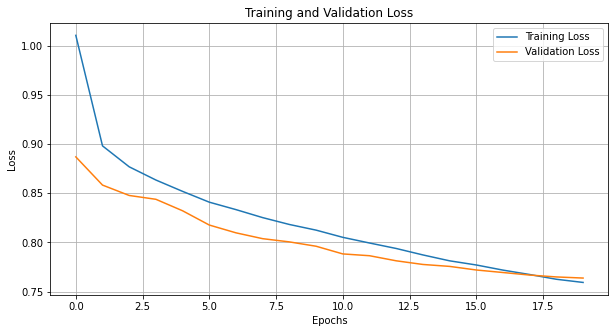


開始訓練 Autoencoder 對抗 PGD 攻擊...


Epoch 1/15 (Validation): 100%|██████████| 69/69 [05:24<00:00,  4.70s/it, loss=0.8770]


Epoch: 1 / 15, Train_loss: 0.9975, Val_loss: 0.8770, Time_taken: 30.35 mins
Validation loss decreased (inf --> 0.877032).  Saving model ...


Epoch 2/15 (Validation): 100%|██████████| 69/69 [05:10<00:00,  4.50s/it, loss=0.8500]


Epoch: 2 / 15, Train_loss: 0.8879, Val_loss: 0.8500, Time_taken: 60.10 mins
Validation loss decreased (0.877032 --> 0.849994).  Saving model ...


Epoch 3/15 (Validation): 100%|██████████| 69/69 [05:11<00:00,  4.52s/it, loss=0.8400]


Epoch: 3 / 15, Train_loss: 0.8637, Val_loss: 0.8400, Time_taken: 89.78 mins
Validation loss decreased (0.849994 --> 0.840018).  Saving model ...


Epoch 4/15 (Validation): 100%|██████████| 69/69 [05:14<00:00,  4.56s/it, loss=0.8226]


Epoch: 4 / 15, Train_loss: 0.8499, Val_loss: 0.8226, Time_taken: 119.60 mins
Validation loss decreased (0.840018 --> 0.822594).  Saving model ...


Epoch 5/15 (Validation): 100%|██████████| 69/69 [05:19<00:00,  4.63s/it, loss=0.8128]


Epoch: 5 / 15, Train_loss: 0.8391, Val_loss: 0.8128, Time_taken: 149.47 mins
Validation loss decreased (0.822594 --> 0.812753).  Saving model ...


Epoch 6/15 (Validation): 100%|██████████| 69/69 [05:14<00:00,  4.56s/it, loss=0.8068]


Epoch: 6 / 15, Train_loss: 0.8293, Val_loss: 0.8068, Time_taken: 179.43 mins
Validation loss decreased (0.812753 --> 0.806753).  Saving model ...


Epoch 7/15 (Validation): 100%|██████████| 69/69 [05:16<00:00,  4.59s/it, loss=0.8058]


Epoch: 7 / 15, Train_loss: 0.8209, Val_loss: 0.8058, Time_taken: 209.50 mins
Validation loss decreased (0.806753 --> 0.805806).  Saving model ...


Epoch 8/15 (Validation): 100%|██████████| 69/69 [05:17<00:00,  4.60s/it, loss=0.7943]


Epoch: 8 / 15, Train_loss: 0.8151, Val_loss: 0.7943, Time_taken: 239.68 mins
Validation loss decreased (0.805806 --> 0.794309).  Saving model ...


Epoch 9/15 (Validation): 100%|██████████| 69/69 [05:18<00:00,  4.61s/it, loss=0.7873]


Epoch: 9 / 15, Train_loss: 0.8068, Val_loss: 0.7873, Time_taken: 269.98 mins
Validation loss decreased (0.794309 --> 0.787293).  Saving model ...


Epoch 10/15 (Validation): 100%|██████████| 69/69 [05:20<00:00,  4.65s/it, loss=0.7850]


Epoch: 10 / 15, Train_loss: 0.8005, Val_loss: 0.7850, Time_taken: 300.20 mins
Validation loss decreased (0.787293 --> 0.785022).  Saving model ...


Epoch 11/15 (Validation): 100%|██████████| 69/69 [05:16<00:00,  4.59s/it, loss=0.7797]


Epoch: 11 / 15, Train_loss: 0.7948, Val_loss: 0.7797, Time_taken: 330.39 mins
Validation loss decreased (0.785022 --> 0.779670).  Saving model ...


Epoch 12/15 (Validation): 100%|██████████| 69/69 [05:17<00:00,  4.61s/it, loss=0.7769]


Epoch: 12 / 15, Train_loss: 0.7889, Val_loss: 0.7769, Time_taken: 360.62 mins
Validation loss decreased (0.779670 --> 0.776946).  Saving model ...


Epoch 13/15 (Validation): 100%|██████████| 69/69 [05:18<00:00,  4.62s/it, loss=0.7724]


Epoch: 13 / 15, Train_loss: 0.7831, Val_loss: 0.7724, Time_taken: 391.01 mins
Validation loss decreased (0.776946 --> 0.772436).  Saving model ...


Epoch 14/15 (Validation): 100%|██████████| 69/69 [05:14<00:00,  4.56s/it, loss=0.7714]


Epoch: 14 / 15, Train_loss: 0.7780, Val_loss: 0.7714, Time_taken: 421.01 mins
Validation loss decreased (0.772436 --> 0.771418).  Saving model ...


Epoch 15/15 (Validation): 100%|██████████| 69/69 [05:15<00:00,  4.57s/it, loss=0.7674]


Epoch: 15 / 15, Train_loss: 0.7737, Val_loss: 0.7674, Time_taken: 451.06 mins
Validation loss decreased (0.771418 --> 0.767360).  Saving model ...


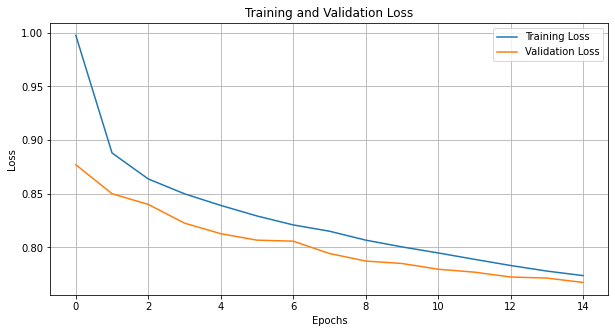

Autoencoder 訓練完成！


In [12]:
# 設定訓練參數
root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
batch_size = 16
img_size = 224
learning_rate_ae = 0.001
num_epochs_ae = 20
use_cuda = True

# 檢查是否有 CUDA 可用
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

# 載入數據並劃分訓練集、驗證集和測試集
train_loader, val_loader, test_loader, class_names = load_afhq_dataset_split(
    root_dir, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=0.5 
)

num_classes = len(class_names)
input_size_vgg = (3, 224, 224) # VGG16 期望的輸入大小

# 初始化目標模型 (VGG16)
#target_model = VGG16For224(input_size=input_size_vgg, num_classes=num_classes, batch_norm=True).to(device)
#載入預訓練的 VGG16 模型權重 (如果需要)
#target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth'))
# 設定超參數 (需要與訓練時保持一致，尤其是模型架構相關的)
num_classes = 3
input_channels = 3  # AFHQ 是 RGB 圖像
# 選擇您保存的權重文件路徑
weights_path = 'resnet18_afhq_subset.pth'
target_model = models.resnet18(pretrained=False) # 注意 pretrained=False，因為我們要載入自己的權重
num_ftrs = target_model.fc.in_features
target_model.fc = nn.Linear(num_ftrs, num_classes)
target_model = target_model.to(device)
try:
    target_model.load_state_dict(torch.load(weights_path, map_location=device))
    target_model.eval()  # 設置為評估模式，禁用 dropout 和 batch norm 的訓練行為
    print(f"成功載入模型權重：{weights_path}")
except FileNotFoundError:
    print(f"錯誤：找不到權重文件 {weights_path}。請檢查文件路徑是否正確。")
    target_model = None

# 初始化 Autoencoder 模型
convAE = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)

# 定義損失函數和優化器
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(convAE.parameters(), lr=learning_rate_ae)

# 開始訓練 Autoencoder 對抗 FGSM 攻擊
print("開始訓練 Autoencoder 對抗 FGSM 攻擊...")
train_autoencoder_adv(target_model, convAE, num_epochs_ae, 'fgsm', train_loader, val_loader, test_loader, device, optimizer_ae, criterion_ae, class_names, load_model=False, file_path='cae_afhq_fgsm_trained.pth')

# 重新初始化 Autoencoder 和優化器以進行下一個攻擊類型的訓練 (可選)
convAE_pgd = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
optimizer_ae_pgd = optim.Adam(convAE_pgd.parameters(), lr=learning_rate_ae)
num_epochs_ae = 15

# 開始訓練 Autoencoder 對抗 PGD 攻擊
print("\n開始訓練 Autoencoder 對抗 PGD 攻擊...")
train_autoencoder_adv(target_model, convAE_pgd, num_epochs_ae, 'pgd', train_loader, val_loader, test_loader, device, optimizer_ae_pgd, criterion_ae, class_names, load_model=False, file_path='cae_afhq_pgd_trained.pth')

print("Autoencoder 訓練完成！")

訓練集和驗證集已縮小至約 50.0% 的大小。
使用設備: cuda
成功載入模型權重：resnet18_afhq_subset.pth
開始訓練 Self-Attention Autoencoder 對抗 FGSM 攻擊...


Epoch 1/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.37it/s, loss=0.8881]


Epoch: 1 / 20, Train_loss: 1.0212, Val_loss: 0.8881, Time_taken: 1.26 mins
Validation loss decreased (inf --> 0.888084).  Saving model ...


Epoch 2/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.44it/s, loss=0.8619]


Epoch: 2 / 20, Train_loss: 0.9043, Val_loss: 0.8619, Time_taken: 2.48 mins
Validation loss decreased (0.888084 --> 0.861887).  Saving model ...


Epoch 3/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.69it/s, loss=0.8502]


Epoch: 3 / 20, Train_loss: 0.8828, Val_loss: 0.8502, Time_taken: 3.69 mins
Validation loss decreased (0.861887 --> 0.850239).  Saving model ...


Epoch 4/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.40it/s, loss=0.8426]


Epoch: 4 / 20, Train_loss: 0.8710, Val_loss: 0.8426, Time_taken: 4.91 mins
Validation loss decreased (0.850239 --> 0.842647).  Saving model ...


Epoch 5/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.72it/s, loss=0.8346]


Epoch: 5 / 20, Train_loss: 0.8628, Val_loss: 0.8346, Time_taken: 6.12 mins
Validation loss decreased (0.842647 --> 0.834581).  Saving model ...


Epoch 6/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.56it/s, loss=0.8270]


Epoch: 6 / 20, Train_loss: 0.8518, Val_loss: 0.8270, Time_taken: 7.35 mins
Validation loss decreased (0.834581 --> 0.827033).  Saving model ...


Epoch 7/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.74it/s, loss=0.8150]


Epoch: 7 / 20, Train_loss: 0.8437, Val_loss: 0.8150, Time_taken: 8.57 mins
Validation loss decreased (0.827033 --> 0.814997).  Saving model ...


Epoch 8/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.78it/s, loss=0.8143]


Epoch: 8 / 20, Train_loss: 0.8351, Val_loss: 0.8143, Time_taken: 9.78 mins
Validation loss decreased (0.814997 --> 0.814346).  Saving model ...


Epoch 9/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.89it/s, loss=0.8088]


Epoch: 9 / 20, Train_loss: 0.8346, Val_loss: 0.8088, Time_taken: 10.96 mins
Validation loss decreased (0.814346 --> 0.808832).  Saving model ...


Epoch 10/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.66it/s, loss=0.7988]


Epoch: 10 / 20, Train_loss: 0.8211, Val_loss: 0.7988, Time_taken: 12.15 mins
Validation loss decreased (0.808832 --> 0.798758).  Saving model ...


Epoch 11/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.77it/s, loss=0.8055]


Epoch: 11 / 20, Train_loss: 0.8130, Val_loss: 0.8055, Time_taken: 13.38 mins
EarlyStopping counter: 1 out of 10


Epoch 12/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.65it/s, loss=0.8416]


Epoch: 12 / 20, Train_loss: 0.8464, Val_loss: 0.8416, Time_taken: 14.59 mins
EarlyStopping counter: 2 out of 10


Epoch 13/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.69it/s, loss=0.8048]


Epoch: 13 / 20, Train_loss: 0.8358, Val_loss: 0.8048, Time_taken: 15.78 mins
EarlyStopping counter: 3 out of 10


Epoch 14/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.58it/s, loss=0.8295]


Epoch: 14 / 20, Train_loss: 0.8581, Val_loss: 0.8295, Time_taken: 16.99 mins
EarlyStopping counter: 4 out of 10


Epoch 15/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.75it/s, loss=0.8033]


Epoch: 15 / 20, Train_loss: 0.8237, Val_loss: 0.8033, Time_taken: 18.19 mins
EarlyStopping counter: 5 out of 10


Epoch 16/20 (Validation): 100%|██████████| 69/69 [00:15<00:00,  4.49it/s, loss=0.7912]


Epoch: 16 / 20, Train_loss: 0.8061, Val_loss: 0.7912, Time_taken: 19.42 mins
Validation loss decreased (0.798758 --> 0.791193).  Saving model ...


Epoch 17/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.81it/s, loss=0.7882]


Epoch: 17 / 20, Train_loss: 0.7952, Val_loss: 0.7882, Time_taken: 20.60 mins
Validation loss decreased (0.791193 --> 0.788219).  Saving model ...


Epoch 18/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.70it/s, loss=0.7830]


Epoch: 18 / 20, Train_loss: 0.7887, Val_loss: 0.7830, Time_taken: 21.79 mins
Validation loss decreased (0.788219 --> 0.783004).  Saving model ...


Epoch 19/20 (Validation): 100%|██████████| 69/69 [00:13<00:00,  5.02it/s, loss=1.2620]


Epoch: 19 / 20, Train_loss: 1.1784, Val_loss: 1.2620, Time_taken: 23.02 mins
EarlyStopping counter: 1 out of 10


Epoch 20/20 (Validation): 100%|██████████| 69/69 [00:14<00:00,  4.81it/s, loss=1.2620]


Epoch: 20 / 20, Train_loss: 1.2690, Val_loss: 1.2620, Time_taken: 24.18 mins
EarlyStopping counter: 2 out of 10


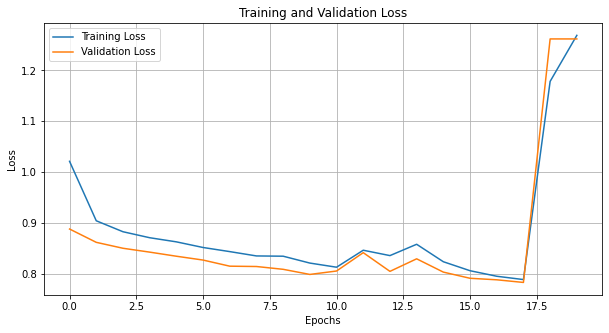


開始訓練 Self-Attention Autoencoder 對抗 PGD 攻擊...


Epoch 1/15 (Validation): 100%|██████████| 69/69 [01:53<00:00,  1.65s/it, loss=0.8880]


Epoch: 1 / 15, Train_loss: 1.0165, Val_loss: 0.8880, Time_taken: 10.43 mins
Validation loss decreased (inf --> 0.887991).  Saving model ...


Epoch 2/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.66s/it, loss=0.8847]


Epoch: 2 / 15, Train_loss: 0.9018, Val_loss: 0.8847, Time_taken: 21.14 mins
Validation loss decreased (0.887991 --> 0.884736).  Saving model ...


Epoch 3/15 (Validation): 100%|██████████| 69/69 [01:55<00:00,  1.67s/it, loss=0.8732]


Epoch: 3 / 15, Train_loss: 0.9040, Val_loss: 0.8732, Time_taken: 31.78 mins
Validation loss decreased (0.884736 --> 0.873161).  Saving model ...


Epoch 4/15 (Validation): 100%|██████████| 69/69 [01:53<00:00,  1.65s/it, loss=0.8553]


Epoch: 4 / 15, Train_loss: 0.8856, Val_loss: 0.8553, Time_taken: 42.28 mins
Validation loss decreased (0.873161 --> 0.855257).  Saving model ...


Epoch 5/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.65s/it, loss=0.8425]


Epoch: 5 / 15, Train_loss: 0.8721, Val_loss: 0.8425, Time_taken: 52.81 mins
Validation loss decreased (0.855257 --> 0.842517).  Saving model ...


Epoch 6/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.66s/it, loss=0.8372]


Epoch: 6 / 15, Train_loss: 0.8619, Val_loss: 0.8372, Time_taken: 63.39 mins
Validation loss decreased (0.842517 --> 0.837217).  Saving model ...


Epoch 7/15 (Validation): 100%|██████████| 69/69 [01:55<00:00,  1.67s/it, loss=0.8279]


Epoch: 7 / 15, Train_loss: 0.8540, Val_loss: 0.8279, Time_taken: 73.99 mins
Validation loss decreased (0.837217 --> 0.827903).  Saving model ...


Epoch 8/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.65s/it, loss=0.8356]


Epoch: 8 / 15, Train_loss: 0.8505, Val_loss: 0.8356, Time_taken: 84.53 mins
EarlyStopping counter: 1 out of 10


Epoch 9/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.66s/it, loss=0.8201]


Epoch: 9 / 15, Train_loss: 0.8426, Val_loss: 0.8201, Time_taken: 95.11 mins
Validation loss decreased (0.827903 --> 0.820121).  Saving model ...


Epoch 10/15 (Validation): 100%|██████████| 69/69 [01:55<00:00,  1.68s/it, loss=0.8568]


Epoch: 10 / 15, Train_loss: 0.8394, Val_loss: 0.8568, Time_taken: 105.63 mins
EarlyStopping counter: 1 out of 10


Epoch 11/15 (Validation): 100%|██████████| 69/69 [01:52<00:00,  1.63s/it, loss=0.8211]


Epoch: 11 / 15, Train_loss: 0.8416, Val_loss: 0.8211, Time_taken: 116.07 mins
EarlyStopping counter: 2 out of 10


Epoch 12/15 (Validation): 100%|██████████| 69/69 [01:55<00:00,  1.67s/it, loss=0.8134]


Epoch: 12 / 15, Train_loss: 0.8416, Val_loss: 0.8134, Time_taken: 126.70 mins
Validation loss decreased (0.820121 --> 0.813397).  Saving model ...


Epoch 13/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.66s/it, loss=0.8244]


Epoch: 13 / 15, Train_loss: 0.8322, Val_loss: 0.8244, Time_taken: 137.30 mins
EarlyStopping counter: 1 out of 10


Epoch 14/15 (Validation): 100%|██████████| 69/69 [01:58<00:00,  1.71s/it, loss=0.8089]


Epoch: 14 / 15, Train_loss: 0.8312, Val_loss: 0.8089, Time_taken: 148.01 mins
Validation loss decreased (0.813397 --> 0.808930).  Saving model ...


Epoch 15/15 (Validation): 100%|██████████| 69/69 [01:54<00:00,  1.66s/it, loss=0.7994]


Epoch: 15 / 15, Train_loss: 0.8154, Val_loss: 0.7994, Time_taken: 158.70 mins
Validation loss decreased (0.808930 --> 0.799367).  Saving model ...


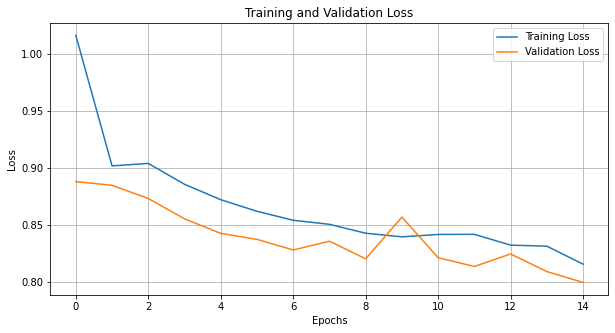

Self-Attention Autoencoder 訓練完成！


In [15]:
# 設定訓練參數
root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
batch_size = 16
img_size = 224
learning_rate_sae = 0.001
num_epochs_sae = 20
use_cuda = True

# 載入數據並劃分訓練集、驗證集和測試集
train_loader, val_loader, test_loader, class_names = load_afhq_dataset_split(
    root_dir, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=0.5 
)

# 檢查是否有 CUDA 可用
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

# 載入數據並劃分訓練集、驗證集和測試集
#train_loader, val_loader, test_loader, class_names = load_afhq_dataset_split(
 #   root_dir, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=0.1
#)
#num_classes = len(class_names)
#input_size_vgg = (3, 224, 224) # VGG16 期望的輸入大小

# 初始化目標模型 (VGG16)
#target_model = VGG16For224(input_size=input_size_vgg, num_classes=num_classes, batch_norm=True).to(device)
# 載入預訓練的 VGG16 模型權重 (如果需要)
#target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth'))
# 設定超參數 (需要與訓練時保持一致，尤其是模型架構相關的)
num_classes = 3
input_channels = 3  # AFHQ 是 RGB 圖像
# 選擇您保存的權重文件路徑
weights_path = 'resnet18_afhq_subset.pth'
target_model = models.resnet18(pretrained=False) # 注意 pretrained=False，因為我們要載入自己的權重
num_ftrs = target_model.fc.in_features
target_model.fc = nn.Linear(num_ftrs, num_classes)
target_model = target_model.to(device)
try:
    target_model.load_state_dict(torch.load(weights_path, map_location=device))
    target_model.eval()  # 設置為評估模式，禁用 dropout 和 batch norm 的訓練行為
    print(f"成功載入模型權重：{weights_path}")
except FileNotFoundError:
    print(f"錯誤：找不到權重文件 {weights_path}。請檢查文件路徑是否正確。")
    target_model = None
    
# 初始化 Self-Attention Autoencoder 模型
convSAE = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size, num_channels=3).to(device)

# 定義損失函數和優化器
criterion_sae = nn.MSELoss()
optimizer_sae = optim.Adam(convSAE.parameters(), lr=learning_rate_sae)

# 開始訓練 Self-Attention Autoencoder 對抗 FGSM 攻擊
print("開始訓練 Self-Attention Autoencoder 對抗 FGSM 攻擊...")
train_sa_autoencoder_adv(target_model, convSAE, num_epochs_sae, 'fgsm', train_loader, val_loader, test_loader, device, optimizer_sae, criterion_sae, class_names, load_model=False, file_path='casae_afhq_fgsm_trained.pth')

# 重新初始化 Self-Attention Autoencoder 和優化器以進行下一個攻擊類型的訓練 (可選)
convSAE_pgd = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
optimizer_sae_pgd = optim.Adam(convSAE_pgd.parameters(), lr=learning_rate_sae)

num_epochs_sae = 15
# 開始訓練 Self-Attention Autoencoder 對抗 PGD 攻擊
print("\n開始訓練 Self-Attention Autoencoder 對抗 PGD 攻擊...")
train_sa_autoencoder_adv(target_model, convSAE_pgd, num_epochs_sae, 'pgd', train_loader, val_loader, test_loader, device, optimizer_sae_pgd, criterion_sae, class_names, load_model=False, file_path='casae_afhq_pgd_trained.pth')

print("Self-Attention Autoencoder 訓練完成！")

In [16]:
def test_defense(model, autoencoder, test_loader, device, attack_type='fgsm', eps_fgsm=0.1, eps_pgd=0.05, alpha=0.01, num_iter=20):
    """
    測試自編碼器作為對抗指定攻擊的防禦，並評估目標模型在還原後的對抗樣本上的準確率。

    Args:
        model (nn.Module): 預訓練的目標分類模型 (例如 VGG16)。
        autoencoder (nn.Module): 訓練好的自編碼器模型。
        test_loader (DataLoader): 測試數據的 DataLoader。
        device (torch.device): 模型運行的設備 (cuda 或 cpu)。
        attack_type (str): 要測試的對抗攻擊類型 ('fgsm' 或 'pgd'，默認為 'fgsm')。
        eps_fgsm (float): FGSM 攻擊的 epsilon 值。
        eps_pgd (float): PGD 攻擊的 epsilon 值。
        alpha (float): PGD 攻擊的步長。
        num_iter (int): PGD 攻擊的迭代次數。

    Returns:
        float: 目標模型在自編碼器還原後的對抗樣本上的分類準確率。
        float: 對抗攻擊和自編碼器處理的總時間。
    """
    model.to(device).eval()
    autoencoder.to(device).eval()
    correct, total = 0, 0
    total_time = 0

    progress_bar = tqdm(test_loader, desc=f"Testing defense against {attack_type}")
    for imgs, labels in progress_bar:
        batch_size = imgs.shape[0]
        imgs = imgs.to(device).clone().detach().requires_grad_(True) # 為攻擊生成啟用梯度
        labels = labels.to(device)

        time_attack = time.time()
        # 生成對抗樣本
        if attack_type == 'fgsm':
            adv_imgs = fgsm_attack(model, imgs, labels, eps_fgsm)
        elif attack_type == 'pgd':
            adv_imgs = pgd_attack(model, imgs, labels, eps_pgd, alpha, num_iter)
        else:
            adv_imgs = imgs # 如果 attack_type 不正確，則使用原始圖像

        time_defense = time.time()
        # 使用自編碼器進行防禦（重建）
        reconstructed_imgs = autoencoder.forward(adv_imgs)
        time_forward = time.time()

        # 使用目標模型預測還原後的圖像
        outputs = model(reconstructed_imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        total_time += (time_forward - time_attack)

    accuracy = correct / total
    print(f"Test Accuracy on {attack_type} attacked and defended images: {accuracy:.4f}")
    print(f'Total time taken for defense and prediction: {total_time:.4f} sec')
    print(f'Average time per sample: {total_time / total:.4f} sec')

    return accuracy, total_time

In [21]:
if __name__ == '__main__':
    # 設定測試參數
    root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
    batch_size = 8
    img_size = 224
    use_cuda = True
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    #載入測試數據
   # _, _, test_loader, class_names = load_afhq_dataset_split(
    #    root_dir, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
   # )
    num_classes = len(class_names)
    print(num_classes)
    # 初始化目標模型 (VGG16) 並載入預訓練權重
    #target_model = VGG16For224(input_size=(3, img_size, img_size), num_classes=num_classes, batch_norm=True).to(device)
    # 假設您已經有訓練好的 VGG16 權重文件
    #target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth', map_location=device))
    # 設定超參數 (需要與訓練時保持一致，尤其是模型架構相關的)
    num_classes = 3
    input_channels = 3  # AFHQ 是 RGB 圖像
    # 選擇您保存的權重文件路徑
    weights_path = 'resnet18_afhq_subset.pth'
    target_model = models.resnet18(pretrained=False) # 注意 pretrained=False，因為我們要載入自己的權重
    num_ftrs = target_model.fc.in_features
    target_model.fc = nn.Linear(num_ftrs, num_classes)
    target_model = target_model.to(device)
    try:
        target_model.load_state_dict(torch.load(weights_path, map_location=device))
        target_model.eval()  # 設置為評估模式，禁用 dropout 和 batch norm 的訓練行為
        print(f"成功載入模型權重：{weights_path}")
    except FileNotFoundError:
        print(f"錯誤：找不到權重文件 {weights_path}。請檢查文件路徑是否正確。")
        target_model = None


    # 初始化自編碼器模型並載入預訓練權重 (FGSM 訓練的)
    autoencoder_fgsm = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    autoencoder_fgsm.load_state_dict(torch.load('cae_afhq_fgsm_trained.pth', map_location=device))
    autoencoder_fgsm.eval()

    # 初始化自編碼器模型並載入預訓練權重 (PGD 訓練的)
    autoencoder_pgd = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    autoencoder_pgd.load_state_dict(torch.load('cae_afhq_pgd_trained.pth', map_location=device))
    autoencoder_pgd.eval()

    # 測試對抗 FGSM 攻擊的防禦
    print("\nTesting defense against FGSM attacks:")
    test_defense(target_model, autoencoder_fgsm, test_loader, device, attack_type='fgsm', eps_fgsm=0.1)

    # 測試對抗 PGD 攻擊的防禦
    print("\nTesting defense against PGD attacks:")
    test_defense(target_model, autoencoder_pgd, test_loader, device, attack_type='pgd', eps_pgd=0.05)

    print("Defense testing completed!")

3
成功載入模型權重：resnet18_afhq_subset.pth

Testing defense against FGSM attacks:


Testing defense against fgsm: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s]


Test Accuracy on fgsm attacked and defended images: 0.2618
Total time taken for defense and prediction: 4.4456 sec
Average time per sample: 0.0040 sec

Testing defense against PGD attacks:


Testing defense against pgd: 100%|██████████| 69/69 [01:06<00:00,  1.03it/s]

Test Accuracy on pgd attacked and defended images: 0.2100
Total time taken for defense and prediction: 52.6232 sec
Average time per sample: 0.0478 sec
Defense testing completed!


In [22]:
# 初始化自編碼器模型並載入預訓練權重 (FGSM 訓練的)
CSA_autoencoder_fgsm = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size, num_channels=3).to(device)
CSA_autoencoder_fgsm.load_state_dict(torch.load('casae_afhq_fgsm_trained.pth', map_location=device)['convSAE_state_dict']) # 直接加載 state_dict
CSA_autoencoder_fgsm.eval()

# 初始化自編碼器模型並載入預訓練權重 (PGD 訓練的)
CSA_autoencoder_pgd = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size, num_channels=3).to(device)
CSA_autoencoder_pgd.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)) # 直接加載 state_dict
CSA_autoencoder_pgd.eval()

# 測試對抗 FGSM 攻擊的防禦
print("\nTesting defense against FGSM attacks:")
test_defense(target_model, CSA_autoencoder_fgsm, test_loader, device, attack_type='fgsm', eps_fgsm=0.1)

# 測試對抗 PGD 攻擊的防禦
print("\nTesting defense against PGD attacks:")
test_defense(target_model, CSA_autoencoder_pgd, test_loader, device, attack_type='pgd', eps_pgd=0.05)

print("Defense testing completed!")


Testing defense against FGSM attacks:


Testing defense against fgsm: 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Test Accuracy on fgsm attacked and defended images: 0.0009
Total time taken for defense and prediction: 4.6627 sec
Average time per sample: 0.0042 sec

Testing defense against PGD attacks:


Testing defense against pgd: 100%|██████████| 69/69 [01:09<00:00,  1.00s/it]

Test Accuracy on pgd attacked and defended images: 0.0509
Total time taken for defense and prediction: 55.0729 sec
Average time per sample: 0.0501 sec
Defense testing completed!


In [19]:
def visualize_attack_defense(model, autoencoder, test_loader, device, attack_type='fgsm', epsilon=0.03, alpha=0.01, num_iter=10, num_samples=8):
    """
    可視化原始圖像、經過攻擊的圖像以及自編碼器還原的圖像。

    Args:
        model (nn.Module): 您的目標分類模型 (用於生成對抗樣本)。
        autoencoder (nn.Module): 您的自編碼器模型。
        test_loader (DataLoader): 測試數據的 DataLoader。
        device (torch.device): 模型運行的設備 (cuda 或 cpu)。
        attack_type (str): 要生成的對抗攻擊類型 ('fgsm' 或 'pgd'，默認為 'fgsm')。
        epsilon (float): FGSM 攻擊的 epsilon 值。
        alpha (float): PGD 攻擊的步長。
        num_iter (int): PGD 攻擊的迭代次數。
        num_samples (int): 要可視化的圖像樣本數量。
    """
    model.to(device).eval()
    autoencoder.to(device).eval()

    images_to_visualize = []
    attacked_images_to_visualize = []
    reconstructed_images_to_visualize = []
    original_labels = []


    data_iter = iter(test_loader)
    for i in range(len(test_loader)): # 迭代足夠的批次來收集樣本
        imgs, labels = next(data_iter)
        imgs = imgs.to(device).clone().detach().requires_grad_(True)
        labels = labels.to(device)

            # 生成對抗樣本
        if attack_type == 'fgsm':
            adv_imgs = fgsm_attack(model, imgs, labels, epsilon)
        elif attack_type == 'pgd':
            adv_imgs = pgd_attack(model, imgs, labels, epsilon, alpha, num_iter)
        else:
            print(f"Unknown attack type: {attack_type}")
            return

            # 使用自編碼器重建圖像
        reconstructed_imgs = autoencoder.forward(adv_imgs)

            # 將結果存儲到列表中（只取前 num_samples 個）
        if len(images_to_visualize) < num_samples:
            images_to_visualize.extend(imgs.cpu().detach())
            attacked_images_to_visualize.extend(adv_imgs.cpu().detach())
            reconstructed_images_to_visualize.extend(reconstructed_imgs.cpu().detach())
            original_labels.extend(labels.cpu().numpy())

        if len(images_to_visualize) >= num_samples:
            break

    # 可視化圖像
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    fig.suptitle(f"Original vs. {attack_type} Attacked vs. Reconstructed Images", fontsize=16)

    for i in range(num_samples):
        # 原始圖像
        original_img = images_to_visualize[i].permute(1, 2, 0)
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min()) # 歸一化到 [0, 1]
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original\nLabel: {original_labels[i]}")
        axes[0, i].axis('off')

        # 經過攻擊的圖像
        attacked_img = attacked_images_to_visualize[i].permute(1, 2, 0)
        attacked_img = (attacked_img - attacked_img.min()) / (attacked_img.max() - attacked_img.min()) # 歸一化到 [0, 1]
        axes[1, i].imshow(attacked_img)
        axes[1, i].set_title(f"Attacked ({attack_type})")
        axes[1, i].axis('off')

        # 還原的圖像
        reconstructed_img = reconstructed_images_to_visualize[i].permute(1, 2, 0)
        reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min()) # 歸一化到 [0, 1]
        axes[2, i].imshow(reconstructed_img)
        axes[2, i].set_title("Reconstructed")
        axes[2, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 調整佈局，避免標題重疊
    plt.show()

成功載入模型權重：resnet18_afhq_subset.pth

Visualizing defense against FGSM attacks:


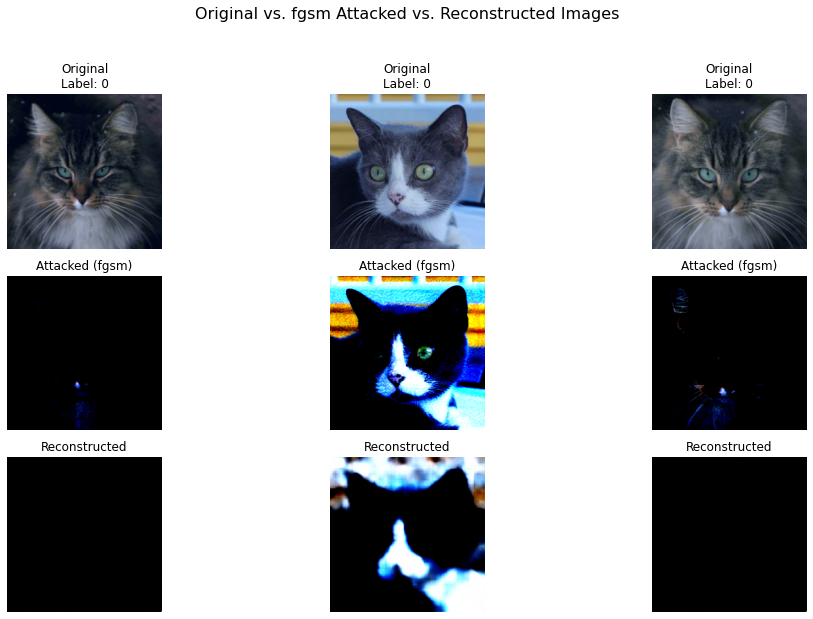


Visualizing defense against PGD attacks:


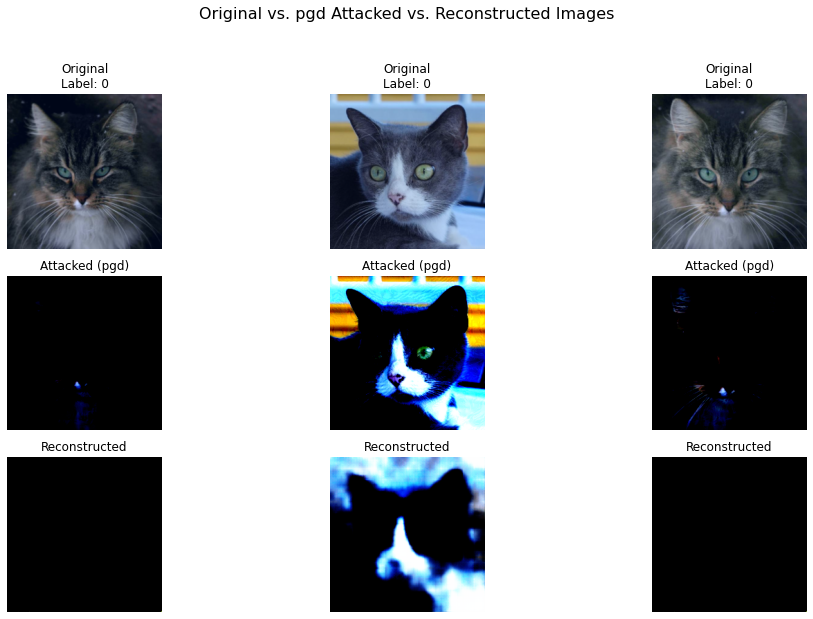


Visualizing defense against FGSM attacks:


KeyboardInterrupt: 

In [23]:
if __name__ == '__main__':
    # 設定參數 (需要與您的訓練和測試環境一致)
    root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
    batch_size = 16
    img_size = 224
    use_cuda = True
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    num_classes = 3 # 根據您的 AFHQ 數據集類別數量
    num_samples_to_visualize = 3 # 您想要可視化的圖像數量

    # 載入測試數據
    #_, _, test_loader, class_names = load_afhq_dataset_split(
    #    root_dir, batch_size=batch_size, img_size=img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
    #)

    # 初始化目標模型 (VGG16) 並載入預訓練權重
    #target_model = VGG16For224(input_size=(3, img_size, img_size), num_classes=num_classes, batch_norm=True).to(device)
    #target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth', map_location=device))
    #target_model.eval()
    num_classes = 3
    input_channels = 3  # AFHQ 是 RGB 圖像
    # 選擇您保存的權重文件路徑
    weights_path = 'resnet18_afhq_subset.pth'
    target_model = models.resnet18(pretrained=False) # 注意 pretrained=False，因為我們要載入自己的權重
    num_ftrs = target_model.fc.in_features
    target_model.fc = nn.Linear(num_ftrs, num_classes)
    target_model = target_model.to(device)
    try:
        target_model.load_state_dict(torch.load(weights_path, map_location=device))
        target_model.eval()  # 設置為評估模式，禁用 dropout 和 batch norm 的訓練行為
        print(f"成功載入模型權重：{weights_path}")
    except FileNotFoundError:
        print(f"錯誤：找不到權重文件 {weights_path}。請檢查文件路徑是否正確。")
        target_model = None
    
    # 初始化自編碼器模型並載入預訓練權重 (FGSM 訓練的)
    autoencoder_fgsm = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        autoencoder_fgsm.load_state_dict(torch.load('cae_afhq_fgsm_trained.pth', map_location=device)['convAE_state_dict'])
    except KeyError:
        autoencoder_fgsm.load_state_dict(torch.load('cae_afhq_fgsm_trained.pth', map_location=device)) # 嘗試直接加載
    autoencoder_fgsm.eval()

    # 初始化自編碼器模型並載入預訓練權重 (PGD 訓練的)
    autoencoder_pgd = ConvAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        autoencoder_pgd.load_state_dict(torch.load('cae_afhq_pgd_trained.pth', map_location=device)['convAE_state_dict'])
    except KeyError:
        autoencoder_pgd.load_state_dict(torch.load('cae_afhq_pgd_trained.pth', map_location=device)) # 嘗試直接加載
    autoencoder_pgd.eval()
    
    CSA_autoencoder_fgsm = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        CSA_autoencoder_fgsm.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)['convSAE_state_dict'])
    except KeyError:
        CSA_autoencoder_fgsm.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)) # 嘗試直接加載
    CSA_autoencoder_fgsm.eval()
    
    CSA_autoencoder_pgd = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        CSA_autoencoder_pgd.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)['convSAE_state_dict'])
    except KeyError:
        CSA_autoencoder_pgd.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)) # 嘗試直接加載
    CSA_autoencoder_pgd.eval()

    # 可視化 FGSM 攻擊和防禦結果
    print("\nVisualizing defense against FGSM attacks:")
    visualize_attack_defense(target_model, autoencoder_fgsm, test_loader, device, attack_type='fgsm', epsilon=0.1, num_samples=num_samples_to_visualize)

    # 可視化 PGD 攻擊和防禦結果
    print("\nVisualizing defense against PGD attacks:")
    visualize_attack_defense(target_model, autoencoder_pgd, test_loader, device, attack_type='pgd', epsilon=0.05, num_iter=40, num_samples=num_samples_to_visualize)

    # 可視化 FGSM 攻擊和防禦結果
    print("\nVisualizing defense against FGSM attacks:")
    visualize_attack_defense(target_model, CSA_autoencoder_fgsm, test_loader, device, attack_type='fgsm', epsilon=0.1, num_samples=num_samples_to_visualize)

    # 可視化 FGSM 攻擊和防禦結果
    print("\nVisualizing defense against PGD attacks:")
    visualize_attack_defense(target_model, CSA_autoencoder_pgd, test_loader, device, attack_type='pgd', epsilon=0.05, num_iter=40, num_samples=num_samples_to_visualize)

    print("Visualization completed!")

In [19]:
def test_attack_accuracy(model, autoencoder, test_loader, device, attack_type='fgsm', eps_fgsm=0.6, eps_pgd=0.15, alpha=0.01, num_iter=10):
    """
    測試模型在指定對抗攻擊下的準確率。

    Args:
        model (nn.Module): 要評估的 PyTorch 模型。
        test_loader (DataLoader): 測試數據的 DataLoader。
        device (torch.device): 模型運行的設備 (cuda 或 cpu)。
        attack_type (str): 要測試的對抗攻擊類型 ('fgsm' 或 'pgd'，默認為 'fgsm')。
        eps (float): FGSM 攻擊的 epsilon 值。
        alpha (float): PGD 攻擊的步長。
        num_iter (int): PGD 攻擊的迭代次數。

    Returns:
        float: 模型在對抗樣本上的準確率。
    """
    model.to(device).eval()
    correct = 0
    total = 0

    progress_bar = tqdm(test_loader, desc=f"Testing against {attack_type}")
    for imgs, labels in progress_bar:
        imgs = imgs.to(device).clone().detach().requires_grad_(True)
        labels = labels.to(device)

            # 生成對抗樣本
        if attack_type == 'fgsm':
            adv_imgs = fgsm_attack(model, imgs, labels, eps_fgsm)
        elif attack_type == 'pgd':
            adv_imgs = pgd_attack(model, imgs, labels, eps_pgd, alpha, num_iter)
        else:
            print(f"Unknown attack type: {attack_type}")
            return None

            # 使用模型預測對抗樣本
        recreate_image = autoencoder.forward(adv_imgs)
        outputs = model(recreate_image)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on {attack_type} attacked images: {accuracy:.4f}")
    return accuracy


In [29]:

if __name__ == '__main__':
    # 設定測試參數 (需要與您的訓練環境一致)
    root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
    batch_size = 16
    img_size = 224
    use_cuda = True
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    num_classes = 3 # 根據您的 AFHQ 數據集類別數量

    # 載入測試數據
    #_, _, test_loader, class_names = load_afhq_dataset_split(
        #root_dir, batch_size=batch_size, img_size=img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
    #)

    # 初始化目標模型 (VGG16) 並載入預訓練權重
    target_model = VGG16For224(input_size=(3, img_size, img_size), num_classes=num_classes, batch_norm=True).to(device)
    try:
        target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth', map_location=device))
    except FileNotFoundError:
        print("錯誤：找不到預訓練的 VGG16 權重文件 'vgg16_afhq_trained.pth'。請檢查文件路徑。")
        exit()
    target_model.eval()

    # 測試在 FGSM 攻擊下的準確率
    print("\nTesting accuracy against FGSM attacks:")
    test_attack_accuracy(target_model, test_loader, device, attack_type='fgsm')

    # 測試在 PGD 攻擊下的準確率
    print("\nTesting accuracy against PGD attacks:")
    test_attack_accuracy(target_model, test_loader, device, attack_type='pgd')

    print("Attack accuracy testing completed!")


Testing accuracy against FGSM attacks:


Testing against fgsm: 100%|██████████| 28/28 [02:29<00:00,  5.32s/it]


Accuracy on fgsm attacked images: 0.1041

Testing accuracy against PGD attacks:


Testing against pgd: 100%|██████████| 28/28 [16:17<00:00, 34.90s/it]

Accuracy on pgd attacked images: 0.0498
Attack accuracy testing completed!


In [23]:
if __name__ == '__main__':
    # 設定測試參數 (需要與您的訓練環境一致)
    root_dir = 'afhq' # 替換為您的 AFHQ 數據集根目錄
    batch_size = 16
    img_size = 224
    use_cuda = True
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    num_classes = 3 # 根據您的 AFHQ 數據集類別數量

    # 載入測試數據
    #_, _, test_loader, class_names = load_afhq_dataset_split(
        #root_dir, batch_size=batch_size, img_size=img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
    #)

    # 初始化目標模型 (VGG16) 並載入預訓練權重
    target_model = VGG16For224(input_size=(3, img_size, img_size), num_classes=num_classes, batch_norm=True).to(device)
    try:
        target_model.load_state_dict(torch.load('vgg16_afhq_trained.pth', map_location=device))
    except FileNotFoundError:
        print("錯誤：找不到預訓練的 VGG16 權重文件 'vgg16_afhq_trained.pth'。請檢查文件路徑。")
        exit()
    target_model.eval()
    
    CSA_autoencoder_fgsm = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        CSA_autoencoder_fgsm.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)['convSAE_state_dict'])
    except KeyError:
        CSA_autoencoder_fgsm.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)) # 嘗試直接加載
    CSA_autoencoder_fgsm.eval()
    
    CSA_autoencoder_pgd = ConvSelfAttentionAutoencoder_AFHQ(device, z_dim=128, image_size=img_size).to(device)
    try:
        CSA_autoencoder_pgd.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)['convSAE_state_dict'])
    except KeyError:
        CSA_autoencoder_pgd.load_state_dict(torch.load('casae_afhq_pgd_trained.pth', map_location=device)) # 嘗試直接加載
    CSA_autoencoder_pgd.eval()

    # 測試在 FGSM 攻擊下的準確率
    print("\nTesting accuracy against FGSM attacks:")
    test_attack_accuracy(target_model, CSA_autoencoder_fgsm, test_loader, device, attack_type='fgsm')

    # 測試在 PGD 攻擊下的準確率
    print("\nTesting accuracy against PGD attacks:")
    test_attack_accuracy(target_model, CSA_autoencoder_pgd, test_loader, device, attack_type='pgd')

    print("Attack accuracy testing completed!")


Testing accuracy against FGSM attacks:


Testing against fgsm: 100%|██████████| 69/69 [14:47<00:00, 12.86s/it]


Accuracy on fgsm attacked images: 0.9755

Testing accuracy against PGD attacks:


Testing against pgd: 100%|██████████| 69/69 [1:45:17<00:00, 91.55s/it]

Accuracy on pgd attacked images: 0.9645
Attack accuracy testing completed!


訓練集和驗證集已縮小至約 10.0% 的大小。

Evaluating ResNet18 on AFHQ dataset under FGSM attack:


Evaluating FGSM attack (epsilon=0.000):   0%|          | 0/14 [00:10<?, ?it/s, acc=68.75%]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


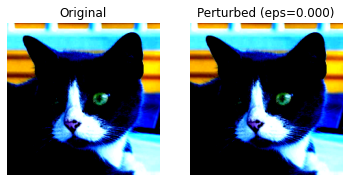

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


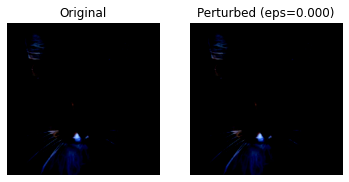

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


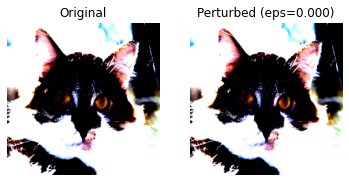

Evaluating FGSM attack (epsilon=0.000): 100%|██████████| 14/14 [00:12<00:00,  1.13it/s, acc=78.83%]


FGSM Attack | Epsilon: 0.000 | Accuracy: 78.83%


Evaluating FGSM attack (epsilon=0.010):   0%|          | 0/14 [00:08<?, ?it/s, acc=68.75%]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


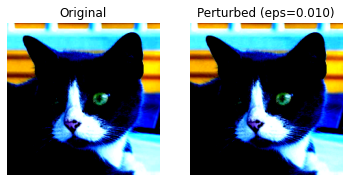

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


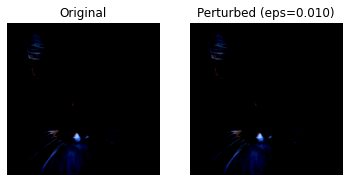

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


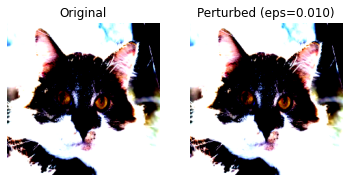

Evaluating FGSM attack (epsilon=0.010): 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, acc=77.48%]


FGSM Attack | Epsilon: 0.010 | Accuracy: 77.48%


Evaluating FGSM attack (epsilon=0.050):   0%|          | 0/14 [00:08<?, ?it/s, acc=50.00%]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x000001FCB93D8860>>
Traceback (most recent call last):
  File "C:\Users\andyc\anaconda3\envs\myenv\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\andyc\anaconda3\envs\myenv\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


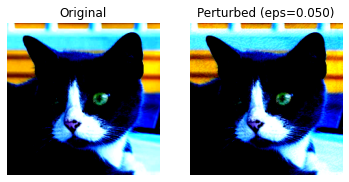

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


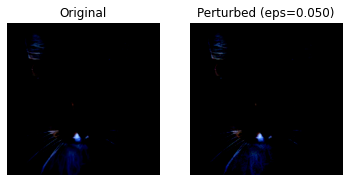

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


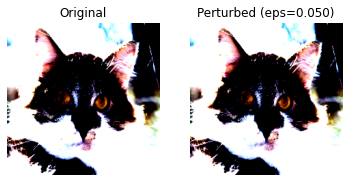

Evaluating FGSM attack (epsilon=0.050): 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, acc=55.41%]


FGSM Attack | Epsilon: 0.050 | Accuracy: 55.41%


Evaluating FGSM attack (epsilon=0.100):   0%|          | 0/14 [00:09<?, ?it/s, acc=31.25%]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


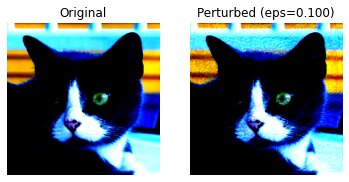

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


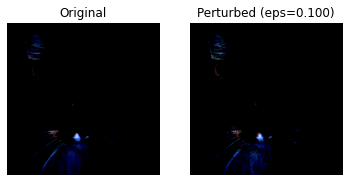

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


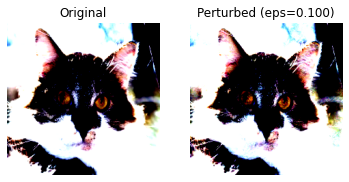

Evaluating FGSM attack (epsilon=0.100): 100%|██████████| 14/14 [00:11<00:00,  1.20it/s, acc=36.94%]


FGSM Attack | Epsilon: 0.100 | Accuracy: 36.94%

Evaluating ResNet18 on AFHQ dataset under PGD attack:


Evaluating PGD attack (epsilon=0.000):   0%|          | 0/14 [00:10<?, ?it/s, acc=68.75%]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


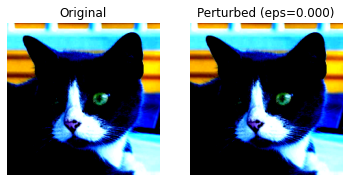

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


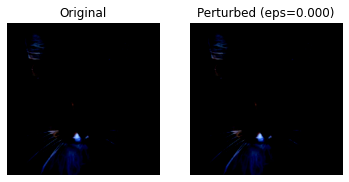

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


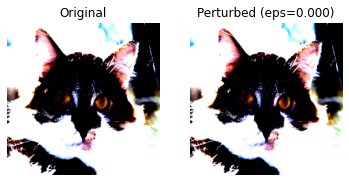

Evaluating PGD attack (epsilon=0.000): 100%|██████████| 14/14 [00:16<00:00,  1.15s/it, acc=78.83%]


PGD Attack | Epsilon: 0.000 | Accuracy: 78.83%


Evaluating PGD attack (epsilon=0.010):   0%|          | 0/14 [00:10<?, ?it/s, acc=62.50%]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


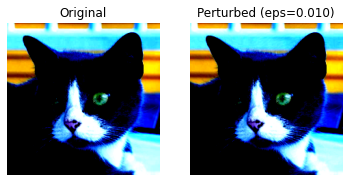

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


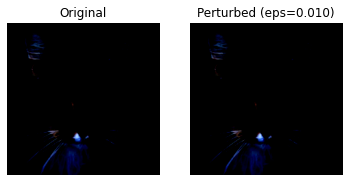

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


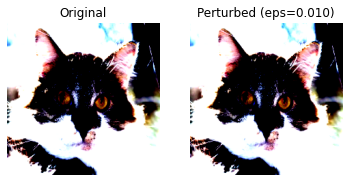

Evaluating PGD attack (epsilon=0.010): 100%|██████████| 14/14 [00:16<00:00,  1.18s/it, acc=72.97%]


PGD Attack | Epsilon: 0.010 | Accuracy: 72.97%


Evaluating PGD attack (epsilon=0.050):   0%|          | 0/14 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [26]:
def evaluate_adversarial_attack_and_visualize(model, test_loader, device, attack_type="FGSM", epsilon=0.3, alpha=0.01, num_iter=40, num_visualize=3):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0
    progress_bar = tqdm(test_loader, desc=f"Evaluating {attack_type} attack (epsilon={epsilon:.3f})")
    visualized_count = 0

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad_(True)
        # 生成對抗樣本
        if attack_type == "FGSM":
            adv_images = fgsm_attack(model, images, labels, epsilon)
        elif attack_type == "PGD":
            adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
        else:
            raise ValueError("Invalid attack type. Choose 'FGSM' or 'PGD'.")

        # 測試對抗樣本的準確率
        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(acc=f"{100 * correct / total:.2f}%")

            # 可視化一些對抗樣本圖像
            if visualized_count < num_visualize:
                original_images = images.cpu().detach()
                perturbed_images = adv_images.cpu().detach()

                for i in range(min(num_visualize - visualized_count, original_images.size(0))):
                    plt.figure(figsize=(6, 3))
                    plt.subplot(1, 2, 1)
                    plt.imshow(original_images[i].permute(1, 2, 0).numpy())
                    plt.title("Original")
                    plt.axis('off')
                    plt.subplot(1, 2, 2)
                    plt.imshow(perturbed_images[i].permute(1, 2, 0).numpy())
                    plt.title(f"Perturbed (eps={epsilon:.3f})")
                    plt.axis('off')
                    plt.show()
                    visualized_count += 1

    acc = 100 * correct / total
    print(f"{attack_type} Attack | Epsilon: {epsilon:.3f} | Accuracy: {acc:.2f}%")

if __name__ == '__main__':
    import torchvision.models as models

    root_dir = 'afhq'
    batch_size = 16
    img_size = 224
    relative_path = 'afhq' # 請將 'afhq' 替換為您的實際 AFHQ 資料集路徑
    absolute_path = os.path.abspath(relative_path)
    num_classes = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加載測試數據
    train_loader, val_loader, test_loader, class_names = load_afhq_dataset_split(
        absolute_path, batch_size, img_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, subset_ratio=0.1 # 減少子集以加快演示
    )

    # 載入訓練好的模型
    model_afhq = models.resnet18(pretrained=False)
    num_ftrs = model_afhq.fc.in_features
    model_afhq.fc = nn.Linear(num_ftrs, num_classes)
    model_afhq.load_state_dict(torch.load("resnet18_afhq_subset.pth", map_location=device)) # 替換為您實際的權重文件路徑
    model_afhq.eval()

    # FGSM 攻擊的 epsilon 值
    fgsm_epsilon = [0.00, 0.01, 0.05, 0.10]

    # PGD 攻擊的 epsilon 值和參數
    pgd_epsilon = [0.00, 0.01, 0.05]
    pgd_alpha = 0.01
    pgd_num_iter = 10 # 減少迭代次數以加快演示

    print("\nEvaluating ResNet18 on AFHQ dataset under FGSM attack:")
    for epsilon in fgsm_epsilon:
        evaluate_adversarial_attack_and_visualize(model_afhq, test_loader, device, attack_type="FGSM", epsilon=epsilon, num_visualize=3)

    print("\nEvaluating ResNet18 on AFHQ dataset under PGD attack:")
    for epsilon in pgd_epsilon:
        evaluate_adversarial_attack_and_visualize(model_afhq, test_loader, device, attack_type="PGD", epsilon=epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, num_visualize=3)